# Описание проблемы

Для повышения умений по программе Data Science принято участие в соревнованиях на платформе Kuggle.com под названием "Стоимость поддержанного автомобиля". Основания задача проекта - предсказания стоимости автомобиля на вторичном рынке. Для исследования получена информация о выставленных на аукционах в разных штатах Америки автомобилях. В ходе работы выбраны следующие основные этапы исследования:
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- общий вывод исследования.

## Описание данных

- train.csv - информация о характеристиках автомобилей (приблизительно 440000), которые будут использоваться в качестве обучающих данных.
- test.csv - информация о характеристиках автомобилей (приблизительно 110000), которые будут использоваться в качестве тестовых данных. 

Описание полей данных:
- date: год выпуска автомобиля;
- make: марка автомобиля;
- model: модель автомобиля определенной марки;
- trim: модификации автомобиля;
- body: тип кузова транспортного средства;
- transmission: тип коробки передач;
- vin: идентификационный номер транспортного средства;
- state: штат, в котором автомобиль выставлен на аукцион;
- condition: состояние автомобилей на момент аукциона;
- odometer: расстояние, пройденное автомобилем с момента выпуска;
- color: цвет кузова автомобиля;
- interior: цвет салона автомобиля;
- seller: продавец автомобиля, автосалоны;
- sellingprice: цена, по которой автомобиль был продан на аукционе;
- saledate: дата продажи автомобиля.

# Подготовка данных

Для выполнения проекта импортируем следующие библиотеки:

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sb
#import ydata_profiling

from category_encoders import TargetEncoder
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                  OrdinalEncoder)

from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import optuna
from optuna.samplers import TPESampler

import shap

import phik

In [47]:
#!pip install shap
#!pip install optuna
#!pip install category_encoders
#!pip install catboost

Загрузим исходные датасеты и данные, полученные путем парсинга [депортамента транспорта США](vpic.nhtsa.dot.gov). Сразу создадим столбцы с месяцем и годом продажи автомобиля. День продажи роли не играет, поэтому эту информацию не будем подгружать.

In [48]:
# Основные данные для работы с датасетом
data_train = pd.read_csv('train.csv')
# Из даты продажи выбираем год и месяц продажи, столбец с датой продажи удаляем из данных
data_train['saleyear'] = pd.to_datetime(data_train['saledate'], utc=True).dt.year
data_train['salemonth'] = pd.to_datetime(data_train['saledate'], utc=True).dt.month
data_train = data_train.drop('saledate', axis=1)

data_test = pd.read_csv('test.csv')
data_test['saleyear'] = pd.to_datetime(data_test['saledate'], utc=True).dt.year
data_test['salemonth'] = pd.to_datetime(data_test['saledate'], utc=True).dt.month
data_test = data_test.drop('saledate', axis=1)

# Данные по отсутсвующим маркам, моделям, модификациям и типам кузова
data_make_train = pd.read_csv('miss_make_auto_train.csv')
data_make_test = pd.read_csv('miss_make_auto_test.csv')

# Данные по отсутствующим типам коробки передач, удалось восстановить лишь 10% информации
data_transm_train = pd.read_csv('miss_transm_auto_test.csv')
data_transm_test = pd.read_csv('miss_transm_auto_test.csv')

Парсинг информации с сайта министерства транспорта США выполнен следующим видом. Стоит учитывать, что за один запрос можно получить информацию не более чем по 50 автомобилям.

    df_train = pd.DataFrame(columns=('VIN', 'Make', 'Model', 'BodyClass', 'Trim'))
    first = 0
    last = 50
    stop_num = miss_vin_train.count()
    for i in range(int(stop_num/50)):
        list_vin_train = '; '.join([str(ele) for ele in list(miss_vin_train[first:last])])
        post_fields = {'format': 'json', 'data':list_vin_train}  #Формат запроса
        data_vin_train = requests.post(url, data=post_fields)  #Сам запрос
        append_df = pd.DataFrame(json.loads(data_vin_train.text)['Results'])
        df_train = pd.concat([df_train, append_df[['VIN', 'Make', 'Model', 'BodyClass', 'Trim']]],
        axis=0, ignore_index=True)
        first += 50
        last += 50
    list_vin_train = '; '.join([str(ele) for ele in list(miss_vin_train[first:stop_num])])
    post_fields = {'format': 'json', 'data':list_vin_train}  #Формат запроса
    data_vin_train = requests.post(url, data=post_fields)  #Сам запрос
    append_df = pd.DataFrame(json.loads(data_vin_train.text)['Results'])
    df_train = pd.concat([df_train, append_df[['VIN', 'Make', 'Model', 'BodyClass', 'Trim']]], axis=0, ignore_index=True)
    
Создаем пустую таблицу с названием столбцов, задаем начальный и конечный номер вина, делим заранее подготовленный список отсуствующих vin номеров по 50 запросов. Выполняем запрос и добавляем информацию в подготовленную таблицу. Проделываем аналогичные манипуляции с отсутствующей информацией по трансмиссии.

Получим информацию по данным в исходных датасетах.

In [49]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saleyear      440236 non-null  int64  
 15  salemonth     440236 non-null  int64  
dtypes: float64(2), int64(4), object(10)
memory usage: 53.7+ MB


In [50]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saleyear      110058 non-null  int64  
 14  salemonth     110058 non-null  int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 12.6+ MB


Предварительный разведывательный анализ данных проведем с помощью библиотеки pandas profiling. Данная библиотека позволяет оперативно ознакомиться с характером данных.

In [51]:
#ydata_profiling.ProfileReport(data_train)

Первоначально обратим внимание на вкладку Alerts, в ней можно увидеть что часть признаков имеют высокую корреляцию между собой. Например состояние, пройденное расстояние и цена продажи сильно коррелируют с датой выпуска автомобиля. Эта информация подтверждается реальным опытом, чем страше автомобиль, тем больше он имеет пробег, хуже состояние и ниже цену.

Второй блок указывает на несбалансированность внутри следующих признаков: трансмиссия, цвет интерьера, год продажи.

Третий блок информации, на которую стоит обратить - пропущенные значения. Следующие признаки имеют от 1,8 до 11,7% пропущенных значений: make, model, trim, condition, body, transmission.

И последним alert является уникальность значений vin номера. У каждого выпущенного автомобиля после 1981 года согласно ISO 3779 имеется свой уникальный vin номер. По данному номеру можно частично расшифровать информацию об авто, а именно марку, цвет, страну, год выпуска и тд.

Полезной информацией так же является matrix и heatmap missing values. По этой информации можно определить, что у признаков make, model, trim и body пропущены одни и те же значения. Подобная ситуация наблюдается аналогично и в тестовых данных. Если бы в соревновании не было бы задачи предсказать стоимость всех автомобилей в тестовой выборке, данные строки следовало бы удалить. Но раз нужно предсказать и такие пропущенные значения, было принято решение получить информацию с сайта министерства транспорта США.

In [52]:
#ydata_profiling.ProfileReport(data_test)

В тестовых данных ситуация аналогична тренировочным, за исключением отсутсвия стоимости продажи автомобиля на аукцион.

## Разведывательный анализ

### Проверка на дубликаты

Первоначально проверим данные на явные дубликаты - это автомобили, которые имеют все одинаковые значения признаков.

Явные дубликаты имеют полное совпадение данных. Проверить можно методом **.duplicated()**, подсчитав количество таких дубликатов.

In [53]:
print(f'Явных дубликатов в тренировочном датасете: {data_train.duplicated().sum()}')
print(f'Явных дубликатов в тестовом датасете: {data_test.duplicated().sum()}')

Явных дубликатов в тренировочном датасете: 0
Явных дубликатов в тестовом датасете: 0


Как видно из вывода, явные дубликаты в обоих датасетах отсутствуют. 

Неявными дубликатами можно назвать повторяющиеся индивидуальные данные, в нашем случае в столбце **vin**. Проведем проверку вычитая из общего количества строк уникальные значения методом .nunique().

In [54]:
print(f'Сумма неуникальных vin в тренировочном датасете: {len(data_train["vin"]) - data_train["vin"].nunique()}')
print(f'Сумма неуникальных vin в тестовом датасете: {len(data_test["vin"]) - data_test["vin"].nunique()}')

Сумма неуникальных vin в тренировочном датасете: 0
Сумма неуникальных vin в тестовом датасете: 0


Каждый автомобиль в исходных датасетах уникальный. 

Проверим случаные строки датасетов.

In [55]:
data_train.sample(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saleyear,salemonth
412531,2012,GMC,Acadia,Denali,SUV,automatic,1gkkrted2cj321875,ca,2.7,26837.0,white,tan,fiserv/usb dealer services northstar exchange,28400,2015,6
310172,2012,Nissan,Altima,2.5 S,Sedan,automatic,1n4al2ap3cn510617,nj,4.4,30976.0,white,gray,nissan-infiniti lt,12700,2015,3
364182,2006,Chevrolet,Equinox,LS,SUV,automatic,2cndl23f266090302,nv,1.9,122102.0,white,tan,dt credit corporation,3000,2015,5
354347,2013,Toyota,Corolla,LE,Sedan,automatic,5yfbu4ee4dp183679,nc,1.9,17186.0,blue,gray,meridian remarketing,10300,2015,1
206853,2012,Chrysler,Town and Country,Touring,Minivan,automatic,2c4rc1bg0cr278065,tx,4.1,45372.0,white,black,santander consumer,15900,2015,2


In [56]:
data_test.sample(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saleyear,salemonth
5588,2005,Toyota,Sienna,XLE 7-Passenger,Minivan,automatic,5tdza22c65s261046,md,1.0,168288.0,blue,brown,jim coleman toyota inc,2014,12
60888,2012,Nissan,Rogue,S,suv,automatic,jn8as5mv7cw391719,co,3.4,31598.0,blue,black,nissan-infiniti lt,2015,6
11211,2013,Chrysler,200,Touring,Sedan,automatic,1c3ccbbb0dn639054,la,4.0,53695.0,red,black,dollar thrifty auto group/faao,2015,1
2065,2007,Cadillac,CTS,Base,Sedan,automatic,1g6dm57t570116715,md,3.4,76069.0,black,gray,wells fargo dealer services,2014,12
44561,2012,BMW,3 Series,328i xDrive,Wagon,NaN,wbauu3c59ca543356,nj,4.4,59270.0,gray,black,financial services remarketing (lease),2015,1


In [57]:
#(data_test.pivot_table(index='color', values='vin', aggfunc='count').sort_values(by='vin')
#          .plot(kind='barh', figsize=(10,10)))
#plt.legend(bbox_to_anchor=(1.02 , 0.2), loc='upper left', borderaxespad= 0)
#plt.title('title')
#plt.show()

 Из случайных строк датасетов видно, что в некоторых столбцах имеются значения с заглавной буквой, такие данные являются неявными дубликатами и их нужно приводить в нижний регистр. Для этого напишем и используем функцию.

In [58]:
make_lower_col = ['make', 'model', 'trim', 'body']
for i in make_lower_col:
    data_train[i] = data_train[i].str.lower()
    data_test[i] = data_test[i].str.lower()

Другие возможные неявные дубликаты в признаках будем преобразовывать в следующем разделе при исследовании данных.

**Промежуточные выводы:** в данных отсутсвуют явные и неявные дубликаты отсутсвуют. Датасеты готовы к предобработке и исследовательскому анализу.

### Год выпуска

Отсортируем года выпуска по автомобилям и выведем уникальные значения.

In [59]:
print(data_train['year'].sort_values().unique())

[1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015]


In [60]:
print(data_test['year'].sort_values().unique())

[1982 1984 1986 1987 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015]


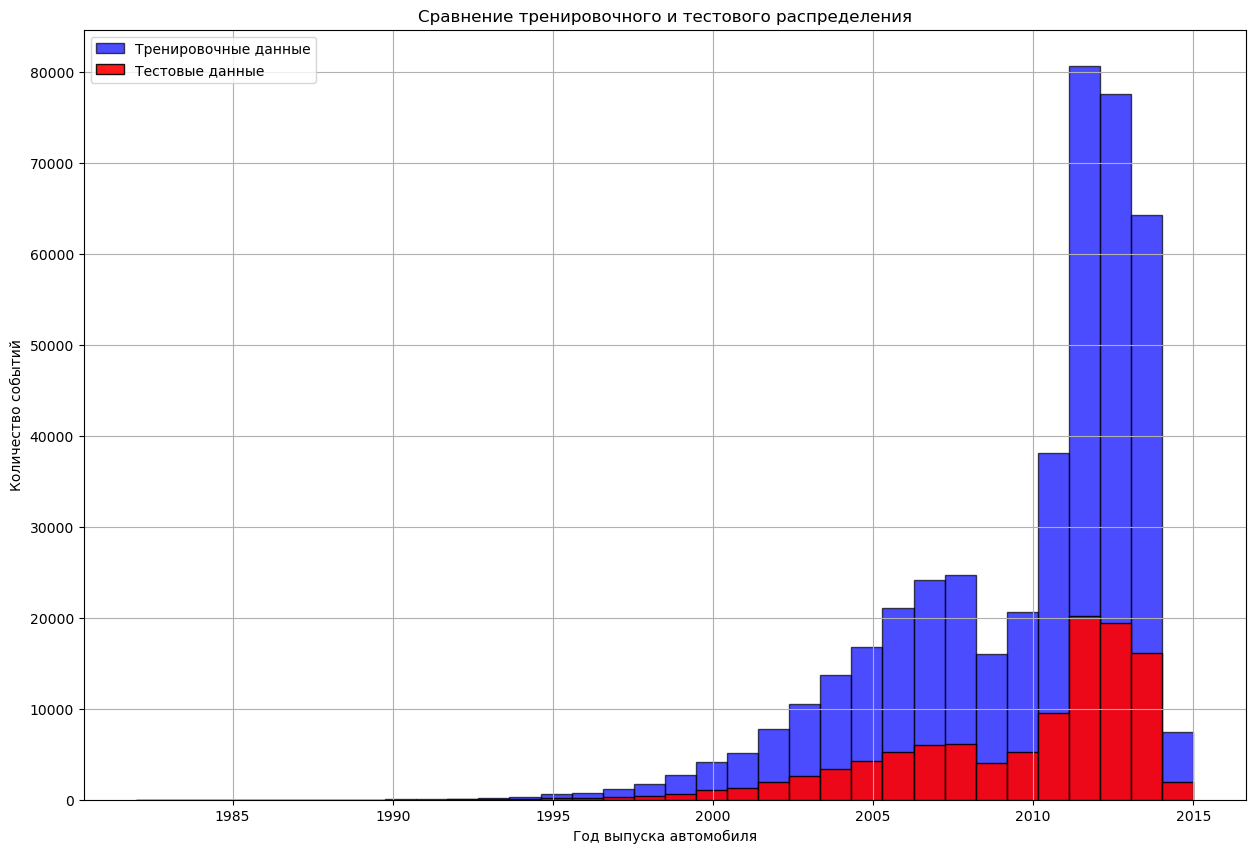

In [61]:
(data_train['year'].sort_values().hist(bins=34, figsize=(15,10), 
                                       alpha=0.7, edgecolor='black', 
                                       color='blue', 
                                       label='Тренировочные данные'))
(data_test['year'].sort_values().hist(bins=34, alpha=0.9, 
                                      color='red', edgecolor='black', 
                                      label='Тестовые данные'))
plt.title('Сравнение тренировочного и тестового распределения')
plt.legend()
plt.ylabel('Количество событий')
plt.xlabel('Год выпуска автомобиля')
plt.show()

Как видно из графика распределение тестового и тренировочного датасета совпадают. В обоих датасетах мода приходится на 2012 год, а автомобилей до 2002 менее 12% от максимального значения. При этом в обоих датасетах самые "раритетные" авто выпущены в 1982 году.

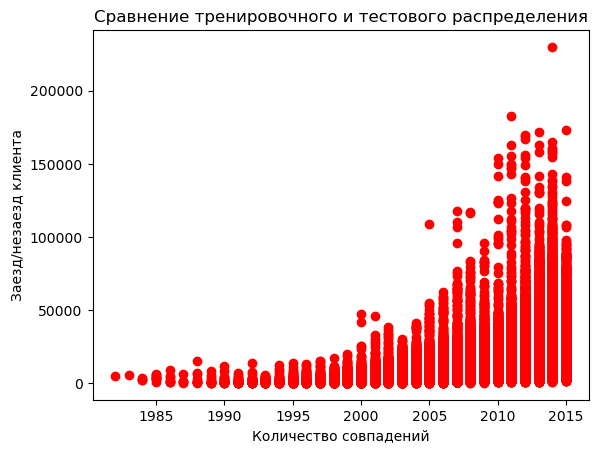

In [62]:
plt.plot(data_train['year'], data_train['sellingprice'], 'ro')
plt.title('Сравнение тренировочного и тестового распределения')
plt.ylabel('Заезд/незаезд клиента')
plt.xlabel('Количество совпадений')
plt.show()

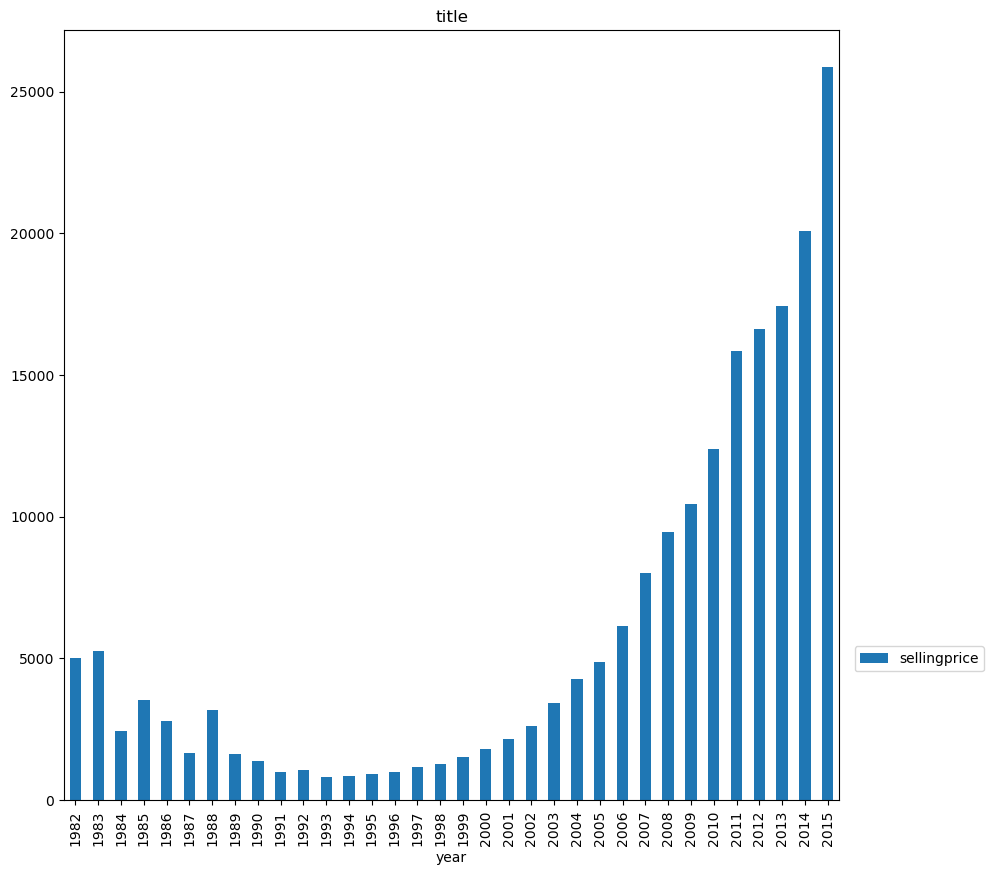

In [63]:
(data_train.pivot_table(index='year', values='sellingprice').sort_values(by='year')
          .plot(kind='bar', figsize=(10,10)))
plt.legend(bbox_to_anchor=(1.02 , 0.2), loc='upper left', borderaxespad= 0)
plt.title('title')
plt.show()

Проверим имеются ли автомобили с годом выпуска позже, чем год продажи. Такое может произойти если автомобиль продан в 2014 году, а год выпуска указан 2015. Логического объяснения, кроме как ошибки заполнения, нет.

In [64]:
data_train[data_train['year']>data_train['saleyear']]['year'].count()

166

In [65]:
data_test[data_test['year']>data_test['saleyear']]['year'].count()

35

Заменим год выпуска на год продажи.

In [66]:
data_train.loc[data_train['year']>data_train['saleyear'], 'year'] = data_train['saleyear']
data_test.loc[data_test['year']>data_test['saleyear'], 'year'] = data_test['saleyear']

### Марка автомобиля

Проверим уникальные значения в названиях марок автомобилей в тренировочном и тестовом датасетах.

In [67]:
data_train['make'].sort_values().unique()

array(['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge',
       'dodge tk', 'dot', 'ferrari', 'fiat', 'fisker', 'ford',
       'ford truck', 'geo', 'gmc', 'gmc truck', 'honda', 'hummer',
       'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia',
       'lamborghini', 'land rover', 'landrover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mazda tk', 'mercedes', 'mercedes-b',
       'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'vw', nan],
      dtype=object)

In [68]:
data_test['make'].sort_values().unique()

array(['acura', 'aston martin', 'audi', 'bentley', 'bmw', 'buick',
       'cadillac', 'chev truck', 'chevrolet', 'chrysler', 'daewoo',
       'dodge', 'ferrari', 'fiat', 'fisker', 'ford', 'ford tk', 'geo',
       'gmc', 'honda', 'hummer', 'hyundai', 'hyundai tk', 'infiniti',
       'isuzu', 'jaguar', 'jeep', 'kia', 'land rover', 'landrover',
       'lexus', 'lincoln', 'lotus', 'maserati', 'mazda', 'mercedes',
       'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'vw', nan],
      dtype=object)

В марках автомобилей имеются дубликаты, в виду малого количества уникальных значений, поправим все в ручную. Каждую марку удалось проверить на адекватность, ведь часть марок не имеют широкую распространенность за территорией США.

In [69]:
replace_dict_train = {'dodge tk': 'dodge',
                      'dot': 'dodge',
                      'ford truck': 'ford',
                      'gmc truck': 'gmc',
                      'landrover': 'land rover',
                      'mazda tk': 'mazda',
                      'mercedes-b': 'mercedes-benz',
                      'mercedes': 'mercedes-benz',
                      'vw': 'volkswagen'}
replace_dict_test = {'chev truck': 'chevrolet',
                     'ford tk': 'ford',
                     'hyundai tk': 'hyundai',
                     'landrover': 'land rover',
                     'mercedes': 'mercedes-benz',
                     'vw': 'volkswagen'}

data_train['make'] = data_train['make'].replace(replace_dict_train)
data_test['make'] = data_test['make'].replace(replace_dict_test)

Марки в обоих датасетах приведены к нормальному виду, неявные дубликаты в данном признаке устранены. Осталось проверить какие марки автомобилей имеются в тестовом датасете и их нету в тренировочном. Ведь в таком случае модели будет сложно предсказать стоимость автомобиля по неизвестной марке.

In [70]:
unique_make_train = data_train['make'].sort_values().unique()
unique_make_test = data_test['make'].sort_values().unique()

for i in unique_make_test:
    if i not in unique_make_train:
        print(i)

lotus
nan


In [71]:
data_test[data_test['make']=='lotus']

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saleyear,salemonth
55695,2007,lotus,exige,s,coupe,manual,sccvc11137hl80911,ca,2.7,16932.0,black,black,gt3 auto group,2015,5


В тренировочном датасете отсутствует лишь марка Lotus. Имеется лишь одна запись об автомобиле данной марки. Такое авто действительно существует и это не ошибка в заполнении поля марки автомобиля. По условиям соревнования удалять строки из тестового датасета запрещено, поэтому оставляем как есть.

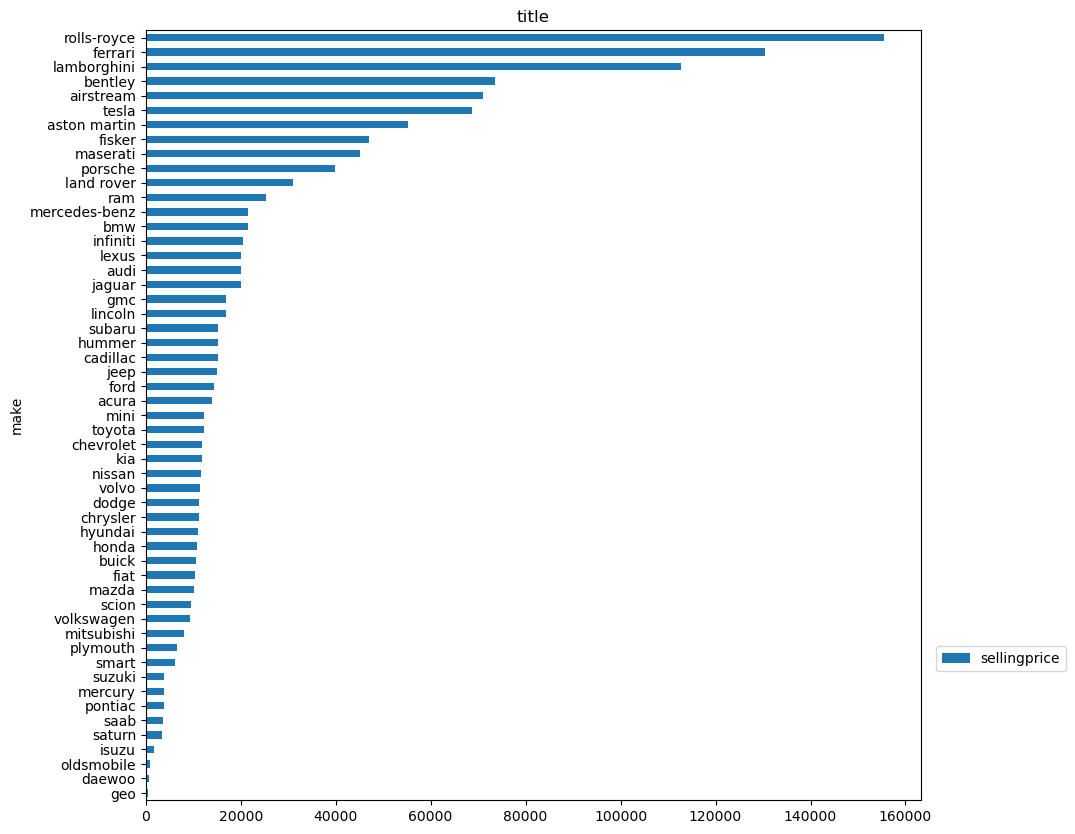

In [72]:
(data_train.pivot_table(index='make', values='sellingprice').sort_values(by='sellingprice')
          .plot(kind='barh', figsize=(10,10)))
plt.legend(bbox_to_anchor=(1.02 , 0.2), loc='upper left', borderaxespad= 0)
plt.title('title')
plt.show()

### Модель автомобиля

In [73]:
print(f'Уникальных моделей авто в тренировочном датасете: {data_train["model"].nunique()}')
print(f'Уникальных моделей авто в тестовом датасете: {data_test["model"].nunique()}')

Уникальных моделей авто в тренировочном датасете: 839
Уникальных моделей авто в тестовом датасете: 746


В данному случае охватить и проверить все модели автомобилей нет возможности. Но в данных заметно, что у некоторых записей имеются одинаковые значения для признаков *модель* и *тип кузова*, причем это значение состоит из "склеиной" строки модели и типа кузова. Такое возможно при ошибке разделения текста на столбцы. Соберем все такие встречающиеся уникальные значения в единый список и корректно разделим на модель и кузов.

In [74]:
train_dubl_model = list(data_train[data_train['model']==data_train['body']]['model'].unique())
train_dubl_model.remove('coupe')
train_dubl_model

['g coupe',
 'g convertible',
 'g sedan',
 'e-series van',
 'tsx sport wagon',
 'cts coupe',
 'elantra coupe',
 'genesis coupe',
 'g37 coupe',
 'beetle convertible',
 'q60 coupe',
 'promaster cargo van',
 'cts-v coupe',
 'cts wagon',
 'g37 convertible',
 'transit van',
 'q60 convertible',
 'ram van',
 'granturismo convertible',
 'cts-v wagon']

In [75]:
test_dubl_model = list(data_test[data_test['model']==data_test['body']]['model'].unique())
test_dubl_model

['g sedan',
 'g coupe',
 'g37 coupe',
 'e-series van',
 'cts coupe',
 'genesis coupe',
 'beetle convertible',
 'promaster cargo van',
 'g convertible',
 'elantra coupe',
 'q60 convertible',
 'q60 coupe',
 'cts-v coupe',
 'tsx sport wagon',
 'granturismo convertible',
 'g37 convertible',
 'transit van',
 'cts wagon']

In [76]:
for i in train_dubl_model:
    model = i.split(sep=' ')[0]
    body = i.split(' ', 1)[1]
    data_train['body'] = data_train['body'].replace(i, body)
    data_train['model'] = data_train['model'].replace(i, model)
    
for i in test_dubl_model:
    model = i.split(sep=' ')[0]
    body = i.split(' ', 1)[1]
    data_test['body'] = data_test['body'].replace(i, body)
    data_test['model'] = data_test['model'].replace(i, model)

### Модификация автомобиля

Проверим количество уникальных значений модификаций в исходных датасетах.

In [77]:
print(f'Уникальных модификаций авто в тренировочном датасете: {data_train["trim"].nunique()}')
print(f'Уникальных модификаций авто в тестовом датасете: {data_test["trim"].nunique()}')

Уникальных модификаций авто в тренировочном датасете: 1850
Уникальных модификаций авто в тестовом датасете: 1457


Количество уникальных модификаций автомобилей велико, при условии что у части записей осутствуют данные значения. Здравый смысл подсказывает 2 варианта решения данной проблемы: 
- замена 3 признаков (марка, модель, модификация) на один единственный, ведь у каждой марки своя уникальная модель, у каждой модели своя уникальная модификация. Данные модели и модификации никаким образом не пересекаются между разными моделями;
- удаление модификации автомобиля в связи с ее абсолютной независимостью между марками автомобилями, единственная зависимость может быть между типом комплектации (например бюджетная, средняя и максимальная).

Оба варианта проверены на тестовом датасете на 4 моделях машинного обучения и наилучший вариант остался за оставлением признаков без изменения. Причем "склейка" признаков сильно ухудшало предсказания моделей.

### Тип кузова

Министерством транспорта США утвержден определенный тип кузова (Body Class) для автомобилей. С перечнем и рисунками типов кузова можно ознакомиться по [следующей ссылке](https://vpic.nhtsa.dot.gov/api/Content/BodyClassImages.zip).

Выведем количество уникальных типов кузова в тренировочном и тестовом датасетах, построим диаграмму количества записей в зависимости от типа их кузова и для тренировочного датасета посчитаем среднюю стоимость автомобиля для каждого типа.

In [78]:
print(f'Уникальных типов кузовов в тренировочном датасете: {data_train["body"].nunique()}')
print(f'Уникальных типов кузовов в тестовом датасете: {data_test["body"].nunique()}')

Уникальных типов кузовов в тренировочном датасете: 27
Уникальных типов кузовов в тестовом датасете: 26


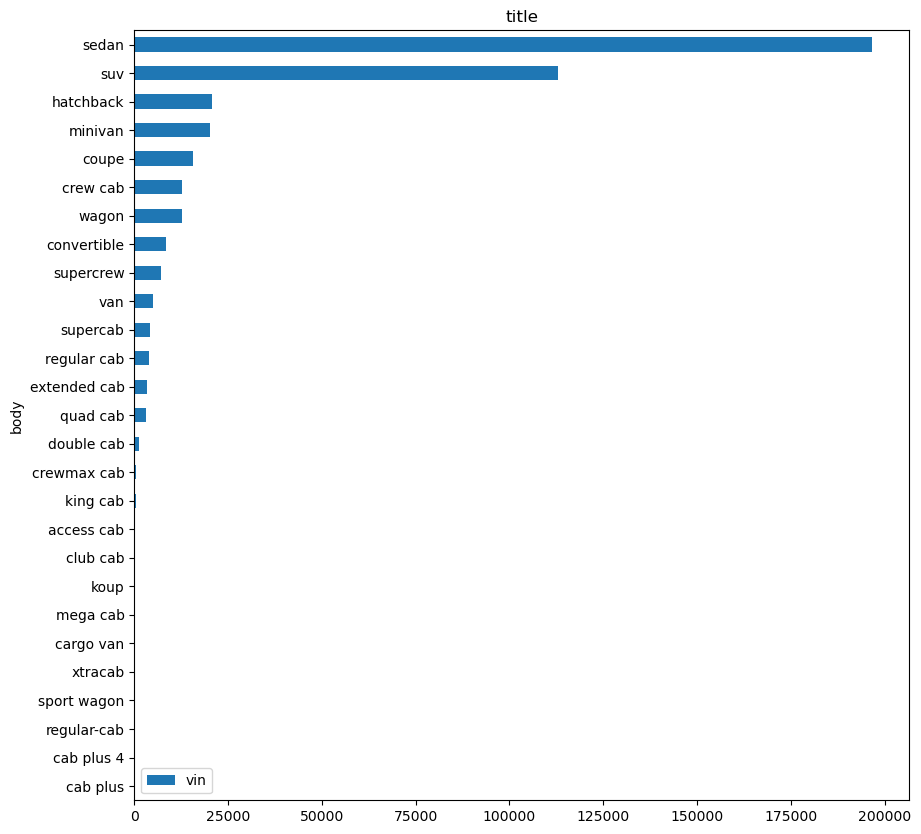

In [79]:
(data_train.pivot_table(index='body', values='vin', aggfunc='count').sort_values(by='vin')
          .plot(kind='barh', figsize=(10,10)))
plt.title('title')
plt.show()

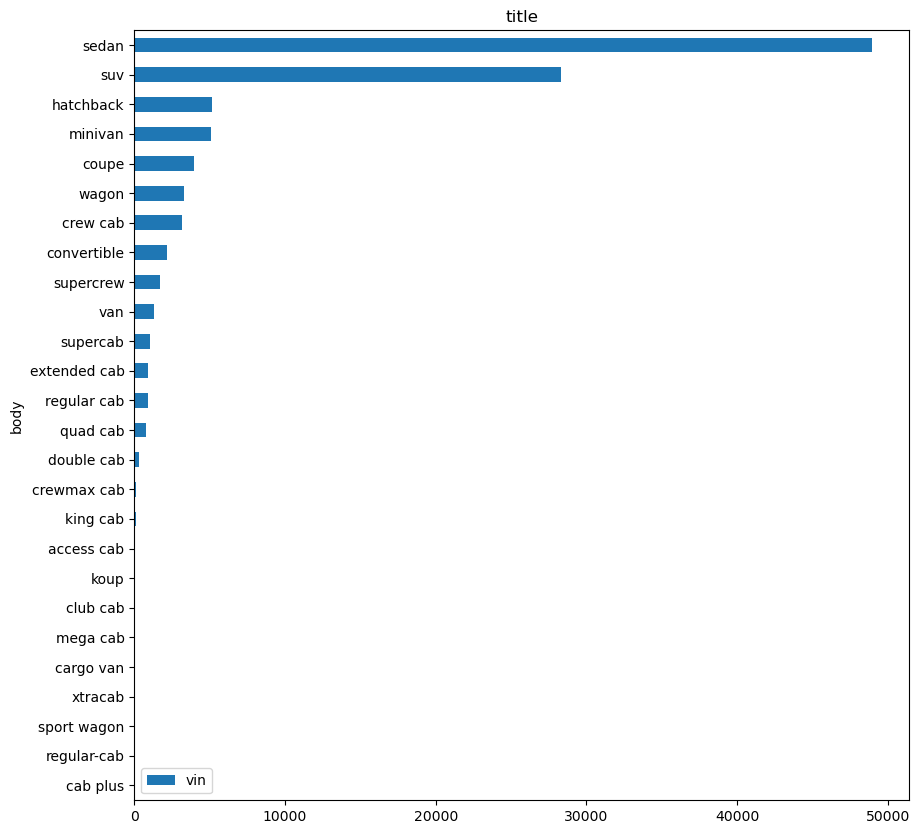

In [80]:
(data_test.pivot_table(index='body', values='vin', aggfunc='count').sort_values(by='vin')
          .plot(kind='barh', figsize=(10,10)))
plt.title('title')
plt.show()

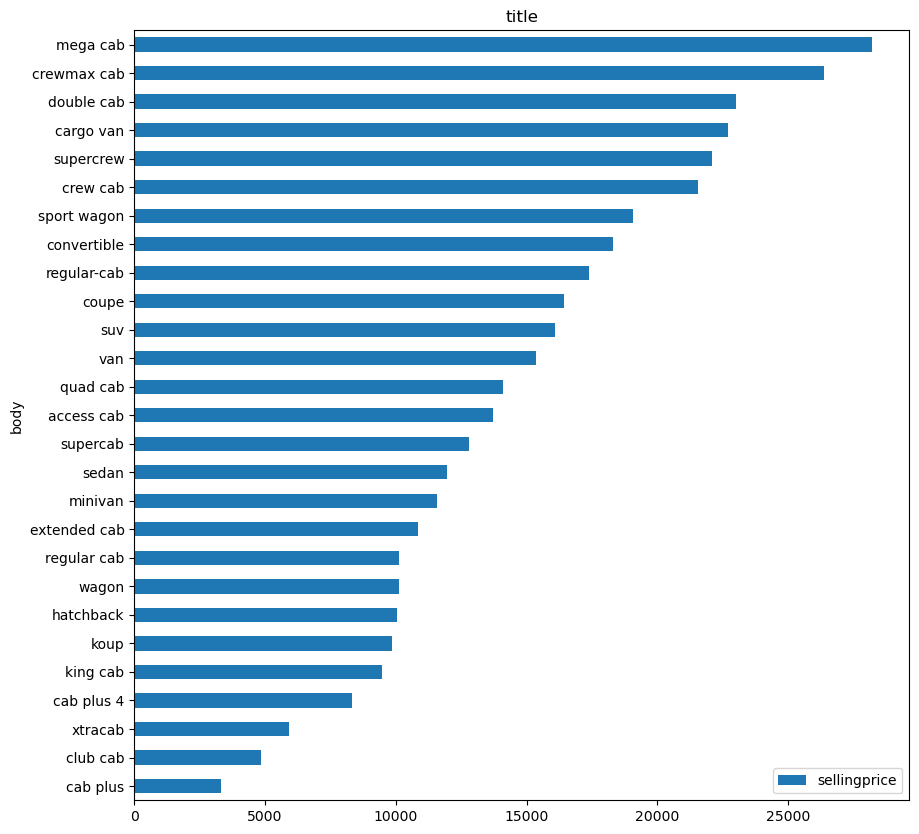

In [81]:
(data_train.pivot_table(index='body', values='sellingprice').sort_values(by='sellingprice')
          .plot(kind='barh', figsize=(10,10)))
plt.title('title')
plt.show()

По данным графикам видно, что имеются кузова с названием "cab" в своем названии, таких типы в общем перечне не существуют. Все эти типы отностятся к типу кузова "pickup". Выдвинута гипотеза об улучшении предсказаний при замене некорректных типов. По результатам проверки гипотезы, оказалось, что замена данных типов ухудшает основную метрику на тренировочном и тестовом датасетах. В связи с чем, принято решение об отказе замены типов кузова.

### Тип трансмиссии

В автомобиле может быть самые различные виды трансмиссии. По типу передачи можно разделить на 2 типа: ручная и автоматическая. У автоматической имеется большое количество вариаций: от гидромеханической до вариаторной. Проверим имеющиеся 

In [82]:
data_train['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

In [83]:
data_test['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

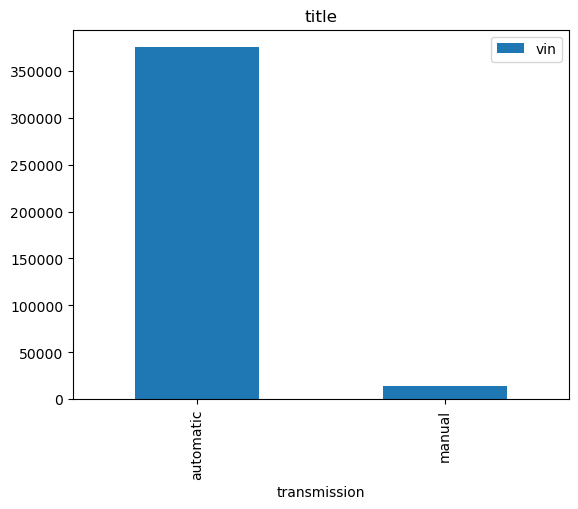

In [84]:
(data_train.pivot_table(index='transmission', values='vin', aggfunc='count').sort_values(by='transmission')
          .plot(kind='bar'))
plt.title('title')
plt.show()

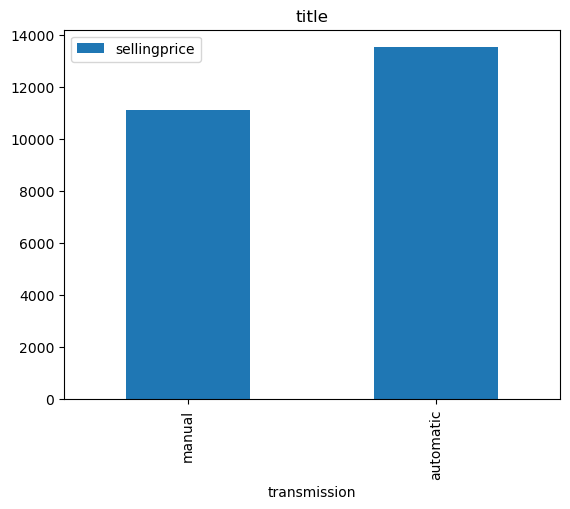

In [85]:
(data_train.pivot_table(index='transmission', values='sellingprice').sort_values(by='sellingprice')
          .plot(kind='bar'))
plt.title('title')
plt.show()

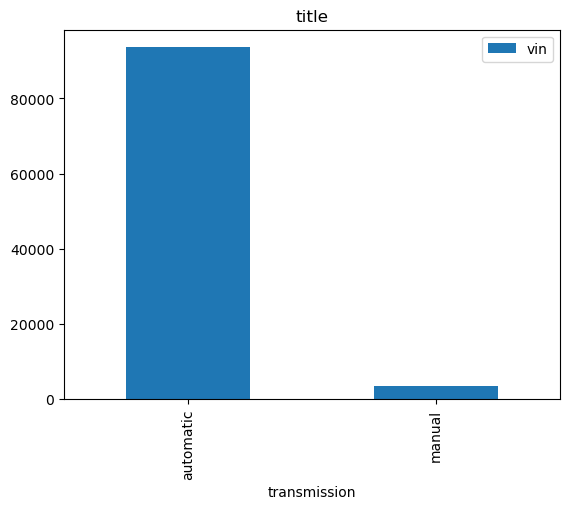

In [86]:
(data_test.pivot_table(index='transmission', values='vin', aggfunc='count').sort_values(by='transmission')
          .plot(kind='bar'))
plt.title('title')
plt.show()

В датасетах представлено 2 типа трансмиссии: ручная и автоматическая. Разница в средней стоимости авто в зависимости от типа приблизительно 2000 долларов.

### Штат регистрации автомобиля

In [87]:
data_train['state'].sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

In [88]:
data_test['state'].sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

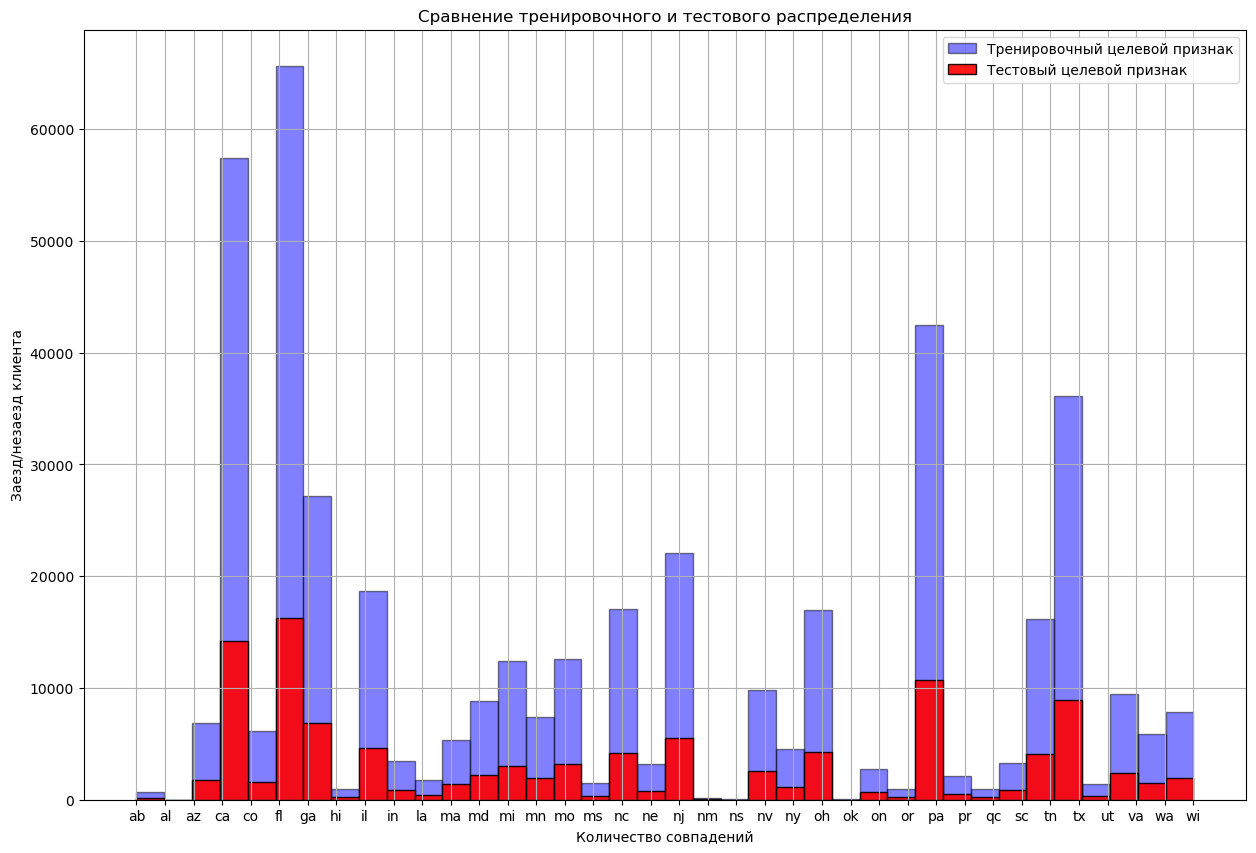

In [89]:
data_train['state'].sort_values().hist(bins=38, figsize=(15,10), alpha=0.5, edgecolor='black', color='blue', label='Тренировочный целевой признак')
data_test['state'].sort_values().hist(bins=38, alpha=0.9, color='red', edgecolor='black', label='Тестовый целевой признак')
plt.title('Сравнение тренировочного и тестового распределения')
plt.legend()
plt.ylabel('Заезд/незаезд клиента')
plt.xlabel('Количество совпадений')
plt.show()

Количество штатов регистрации автомобиля и их распределение в обоих датасетах совпадают. Наибольшее количество автомобилей зарегистрировано во Флориде и Калифорнии. Данную тендецию можно объяснить из ответов сети Интренет.

**Флорида** - один из лучших штатов для покупки подержанного автомобиля. Транспортные средства во Флориде примерно на 10% дешевле, чем в среднем по стране. Около 20,5% населения Флориды старше 65 лет. Поскольку население Флориды стареет, многие водители каждый год сдают свои машины из-за ухудшения зрения или других возрастных причин, по которым они больше не садятся за руль. Пожилые люди также, как правило, лучше заботятся о своих транспортных средствах, чем молодые.

Это приводит к тому, что предложение подержанных автомобилей во Флориде велико, что позволяет ценам оставаться низкими. Кроме того, более состоятельные жители Флориды, как правило, часто продают свои автомобили, чтобы купить новейшие модели.

Это также открывает рынок для автомобилей класса люкс по значительно более низким ценам. В качестве бонуса большинство транспортных средств Флориды не подвергались износу от снега или соли, используемой на дорогах зимой, поэтому они, вероятно, в отличном состоянии.

С другой стороны, **Калифорния** является наихудшим штатом по начальной стоимости автомобиля. В Калифорнии в целом высокая стоимость жизни, а рынок подержанных автомобилей гораздо меньше. Это делает их цены намного выше, а конкуренцию за них более жесткой.

### Состояние автомобиля автомобиля

Состояние автомобиля имеет ключевую важность при формировании стоимости автомобиля. Но стоит учитывать, что у разных аукционов и продавцов могут отличаться критерии оценки автомобиля. Так же неизвестно состояние автомобиля оценивалось как техническое или в совокупности с внешним состоянием.

<AxesSubplot:>

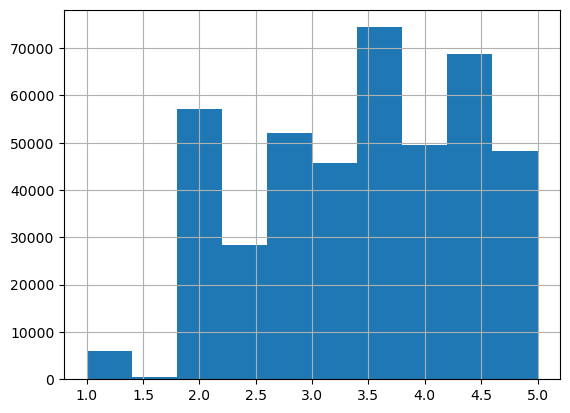

In [90]:
data_train['condition'].hist()

<AxesSubplot:>

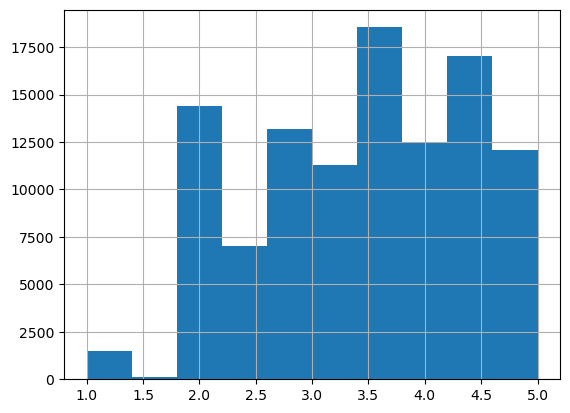

In [91]:
data_test['condition'].hist()

Для обоих датасетов наибольшее количество автомобилей имеют состояние от 3.4 до 4.5. Проверим на тестовой выборке зависимость состояния и средней стоимости автомобиля.

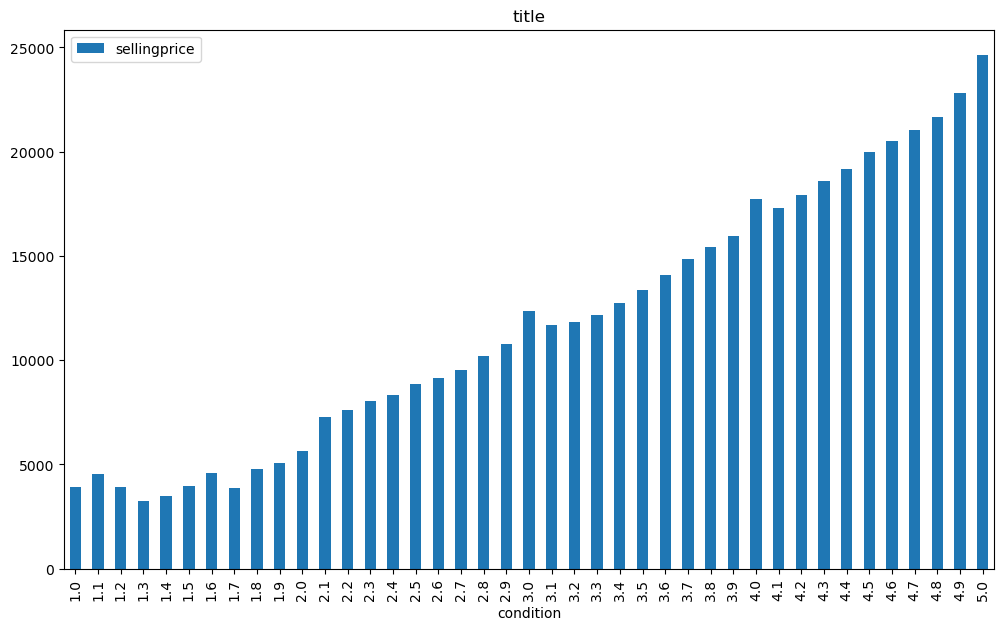

In [92]:
(data_train.pivot_table(index='condition', values='sellingprice').sort_values(by='condition')
          .plot(kind='bar', figsize=(12,7)))
plt.title('title')
plt.show()

На графике в явном виде имеется линейная зависимость между состоянием и средней стоимостью автомобиля. Конечно имеются отклонения у состояния равное 3.0 и 4.0, а так же от 1.0 до 1.3. 

При предварительной оценке исходных данных обнаружено, что имеются автомобили состояние которых имеет наименьшую оценку, а стоимость превышает десятки тысяч долларов.

In [93]:
data_train[data_train['condition']==1]['sellingprice'].sort_values(ascending=False).head(10)

74035     47200
311558    46300
352593    40000
366278    40000
221828    39750
254760    37200
412423    37000
369282    35800
17104     35750
193862    34750
Name: sellingprice, dtype: int64

### Пробег автомобиля

Пробег автомобиля косвенно влияет на стоимость автомобиля, чем больше у авто пробег, тем больше он изношен, и тем ниже цена.

In [94]:
data_train['odometer'].describe()

count    440167.000000
mean      68344.421604
std       53542.203908
min           1.000000
25%       28258.000000
50%       52098.000000
75%       99272.000000
max      999999.000000
Name: odometer, dtype: float64

Среди данных более 75% автомобилей имеет пробег менее 100 тысяч миль, 25% менее 28 тысяч миль. При том имеются автомобили с пробегом 1 миля и 1 млн миль. 1 миля на практике не может быть, потому что даже абсолютно новый автомобиль, купленный в салоне, имеет пробег более 20 миль (техническая проверка систем авто). Расстояние же более 1 млн миль так же редки, но возможны. Проверим количество автомобилей с крайними значениями пробега.

In [95]:
print(f'Количество автомобилей с пробегом 1 миля в тренировочном датасете:' 
      f'{data_train[data_train["odometer"]==1]["odometer"].count()}')
print(f'Количество автомобилей с пробегом 1 миля в тестовом датасете: '
      f'{data_test[data_test["odometer"]==1]["odometer"].count()}')

Количество автомобилей с пробегом 1 миля в тренировочном датасете:1059
Количество автомобилей с пробегом 1 миля в тестовом датасете: 246


In [96]:
print(f'Количество автомобилей с пробегом 1 млн миль в тренировочном датасете:' 
      f'{data_train[data_train["odometer"]==1e6-1]["odometer"].count()}')
print(f'Количество автомобилей с пробегом 1 млн миль в тестовом датасете: '
      f'{data_test[data_test["odometer"]==1e6-1]["odometer"].count()}')

Количество автомобилей с пробегом 1 млн миль в тренировочном датасете:55
Количество автомобилей с пробегом 1 млн миль в тестовом датасете: 17


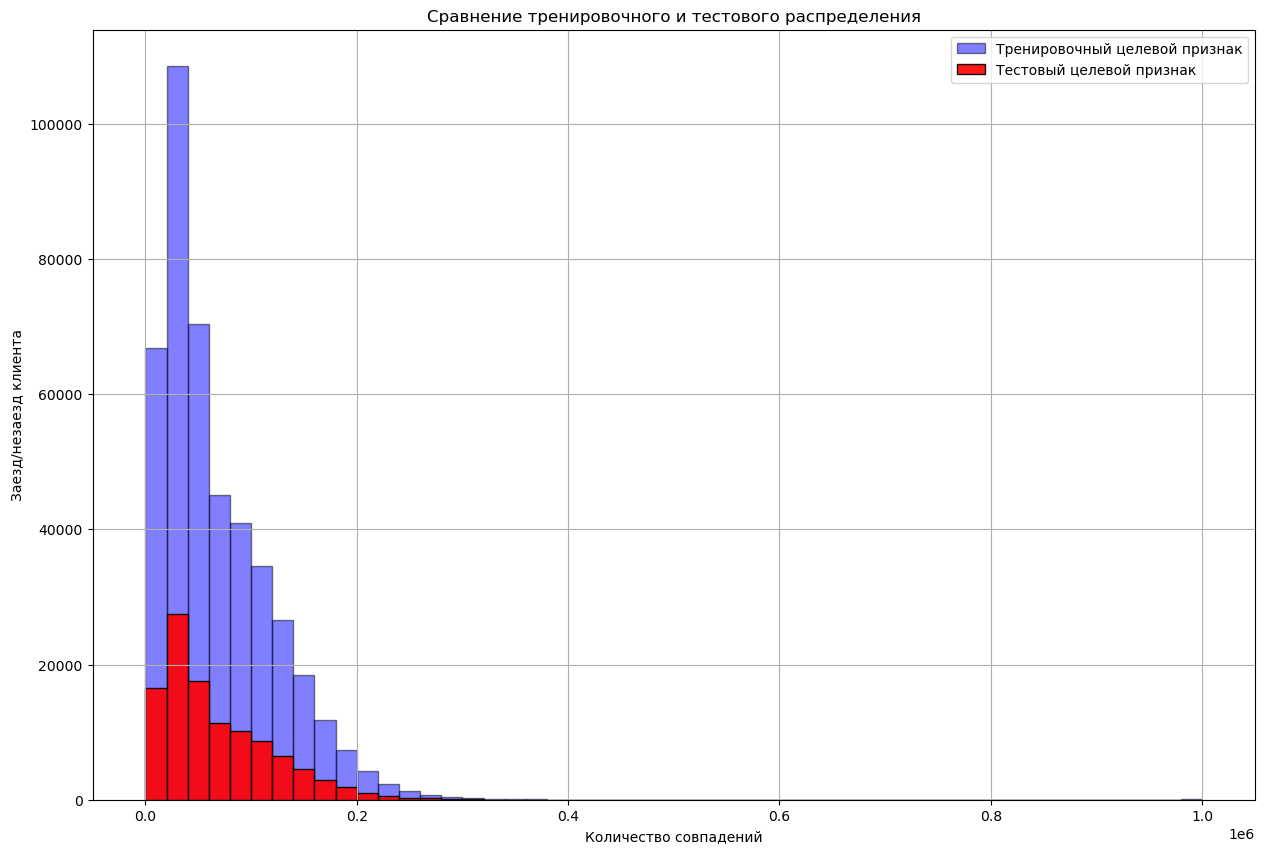

In [97]:
data_train['odometer'].hist(bins=50, figsize=(15,10), alpha=0.5, edgecolor='black', color='blue', label='Тренировочный целевой признак')
data_test['odometer'].hist(bins=50, alpha=0.9, edgecolor='black', color='red', label='Тестовый целевой признак')
plt.title('Сравнение тренировочного и тестового распределения')
plt.legend()
plt.ylabel('Заезд/незаезд клиента')
plt.xlabel('Количество совпадений')
plt.show()

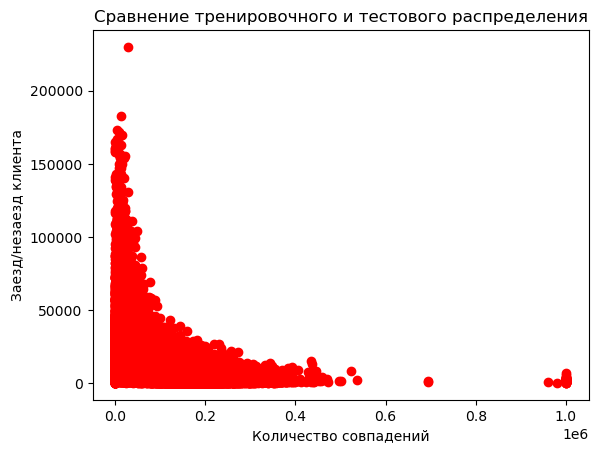

In [98]:
plt.plot(data_train['odometer'], data_train['sellingprice'], 'ro')
plt.title('Сравнение тренировочного и тестового распределения')
plt.ylabel('Заезд/незаезд клиента')
plt.xlabel('Количество совпадений')
plt.show()

Как вариант, можно было разделить показания одометра на группы, например до 10 тысяч миль, от 10 до 50 тысяч миль и тд. Но данный вариант сильно ухудшал предсказания моделей.

Заменим показания одометра для автомобилей имеющих минимальное и максимальное значение на среднее. В данном случае результаты предсказаний моделей улучшились.

In [99]:
data_train.loc[(data_train['odometer']==1)|(data_train['odometer']==999999), 'odometer'] = data_train['odometer'].mean()
data_test.loc[(data_test['odometer']==1)|(data_test['odometer']==999999), 'odometer'] = data_test['odometer'].mean()

### Цвет кузова и салона автомобиля

Среди признаков имеются такие цвет кузова и салона автомобиля. При покупке автомобиля за определенные цвета кузова приходится доплачивать небольшую цену, которая при прочих равных отсутствует у поддержаных автомобилей. Цвет салона так же имеет малое отношение к формированию стоимости авто. Проверим как часто встречаются тот или иной цвет кузова и салона.

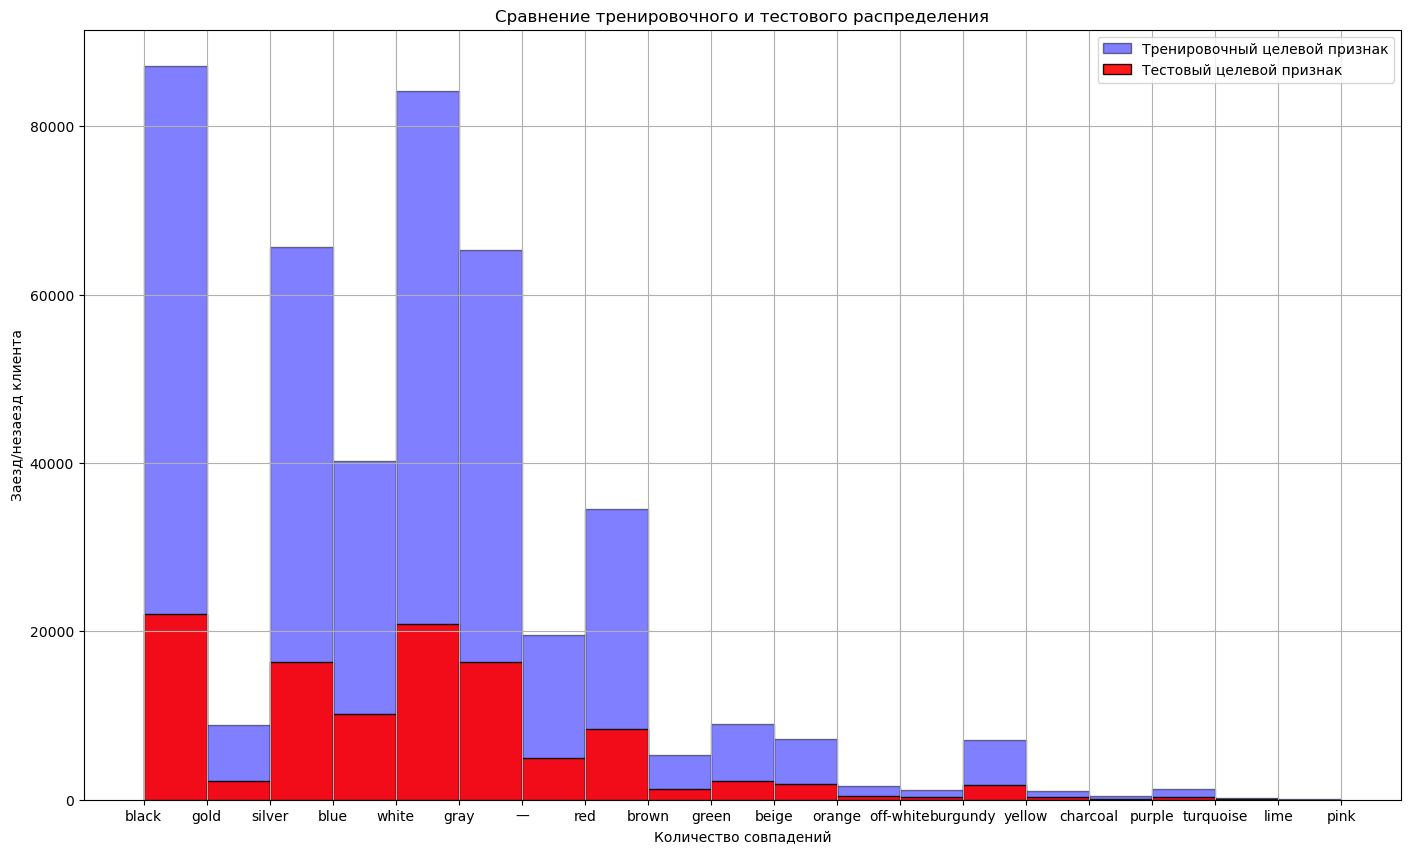

In [100]:
data_train['color'].hist(bins=19, figsize=(17,10), alpha=0.5, edgecolor='black', color='blue', label='Тренировочный целевой признак')
data_test['color'].hist(bins=19, alpha=0.9, color='red', edgecolor='black', label='Тестовый целевой признак')
plt.title('Сравнение тренировочного и тестового распределения')
plt.legend()
plt.ylabel('Заезд/незаезд клиента')
plt.xlabel('Количество совпадений')
plt.show()

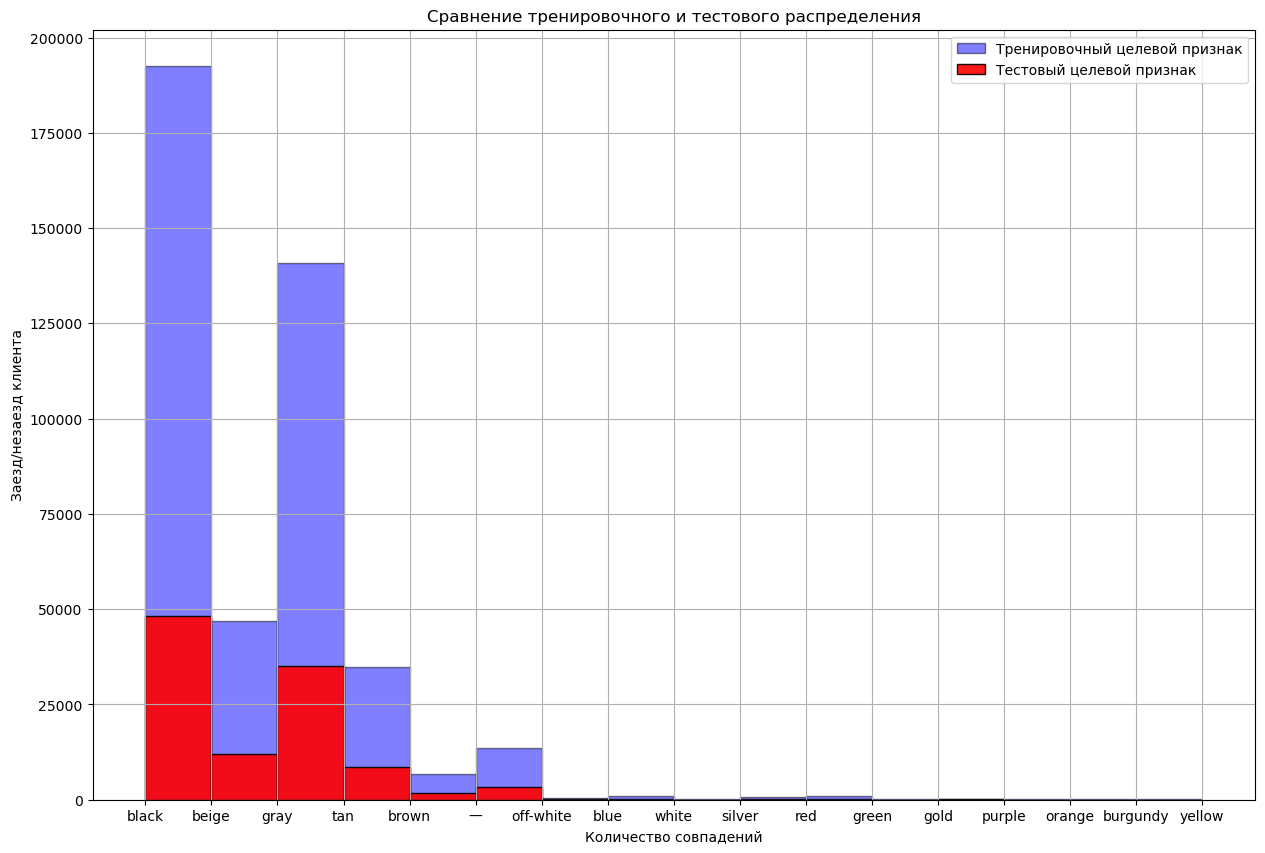

In [101]:
data_train['interior'].hist(bins=16, figsize=(15,10), alpha=0.5, edgecolor='black', color='blue', label='Тренировочный целевой признак')
data_test['interior'].hist(bins=16, alpha=0.9, color='red', edgecolor='black', label='Тестовый целевой признак')
plt.title('Сравнение тренировочного и тестового распределения')
plt.legend()
plt.ylabel('Заезд/незаезд клиента')
plt.xlabel('Количество совпадений')
plt.show()

Как видно из гистограмм среди цветов преобладают определенные. Путем проверки на тренировочном и тестовом датасетах выявлено, что цвет интерьера не улучшает ключевую метрику. Поэтому данный признак не будем использовать в обучении и предсказании моделей.

Среди цвета кузова выберем 6 наиболее часто встречающихся, а остальным присвоим значение "other". 

Восстановить пропуски в признаке цвет невозможно, поэтому заменим на значение "unknown". Такое же значение присвоим тем авто, у которых стоит прочерк у признака цвета кузова.

In [102]:
top_color = ['black', 'white', 'silver', 'gray', 'blue', 'red']
# Преобразовываем датасеты
data_train['color'] = (data_train['color']
                         .apply(lambda x: 'other' if x not in top_color else x))

data_test['color'] = (data_test['color']
                         .apply(lambda x: 'other' if x not in top_color else x))

In [103]:
data_train['color'] = data_train['color'].fillna('unknown')
data_train['color'] = data_train['color'].str.replace('—', 'unknown')

data_test['color'] = data_test['color'].fillna('unknown')
data_test['color'] = data_test['color'].str.replace('—', 'unknown')

### Продавец автомобиля

In [104]:
print(f'Уникальных продавцов в тренировочном датасете: {data_train["seller"].nunique()}')
print(f'Уникальных продавцов в тестовом датасете: {data_test["seller"].nunique()}')

Уникальных продавцов в тренировочном датасете: 13025
Уникальных продавцов в тестовом датасете: 7623


Уникальных продавцов автомобилей слишком много, при этом стоит учитывать что не все продавцы имеются в тестовом датасете и часть продавцов может быть в тестовом, но отсутствовать в тренировочном датасете. 

Удаление данного столбца ухудшило предсказания моделей машинного обучения, поэтому принято решение оставить этот признак.

### Год и месяц продажи автомобиля

В исходных данных представлены продаже за 2014 и 2015 года.

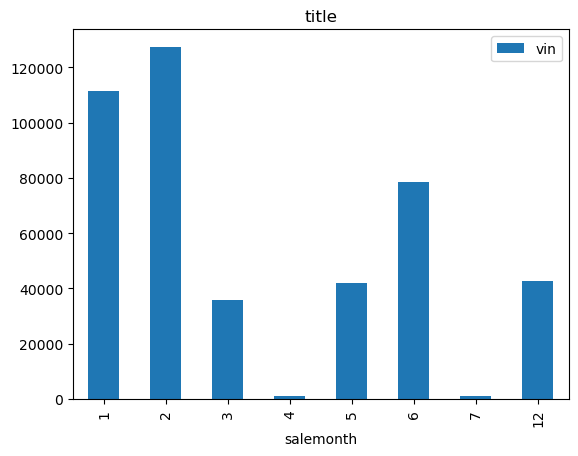

In [105]:
(data_train.pivot_table(index='salemonth', values='vin', aggfunc='count')
          .plot(kind='bar'))
plt.title('title')
plt.show()

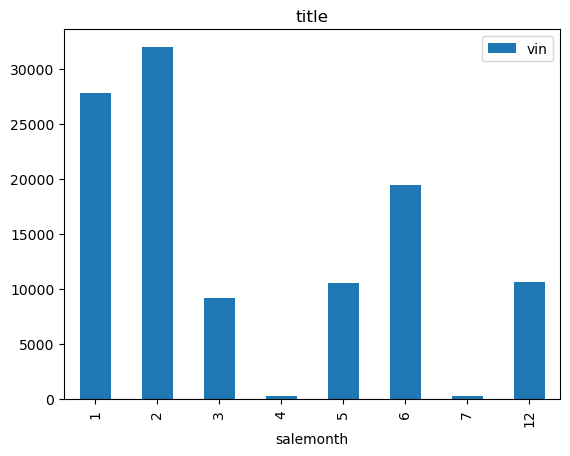

In [106]:
(data_test.pivot_table(index='salemonth', values='vin', aggfunc='count')
          .plot(kind='bar'))
plt.title('title')
plt.show()

В исходных данных прослеивается некая сезонность продажи автомобилей. С августа по декабрь отсутствуют продажи автомобилей.

## Преобразования данных

По возможности заменим пропуски данными с сайта департамента транспорта США. Для этого объединим таблицы по признаку "vin"

In [107]:
data_train = data_train.merge(data_make_train, left_on='vin', right_on='VIN', how='left')
data_test = data_test.merge(data_make_test, left_on='vin', right_on='VIN', how='left')

data_train = data_train.merge(data_transm_train, left_on='vin', right_on='VIN', how='left')
data_test = data_test.merge(data_transm_test, left_on='vin', right_on='VIN', how='left')

Заменим пропуски новыми данными и удалим лишние столбцы.

In [109]:
data_train['make'] = data_train['make'].fillna(data_train['Make'])
data_train['model'] = data_train['model'].fillna(data_train['Model'])
data_train['trim'] = data_train['trim'].fillna(data_train['Trim'])
data_train['body'] = data_train['body'].fillna(data_train['BodyClass'])
data_train['transmission'] = data_train['transmission'].fillna(data_train['TransmissionStyle'])
data_train = data_train.drop(['VIN_x', 'Make', 'Model', 'BodyClass', 'Trim', 'VIN_y', 'TransmissionStyle'], axis=1)

data_test['make'] = data_test['make'].fillna(data_test['Make'])
data_test['model'] = data_test['model'].fillna(data_test['Model'])
data_test['trim'] = data_test['trim'].fillna(data_test['Trim'])
data_test['body'] = data_test['body'].fillna(data_test['BodyClass'])
data_test['transmission'] = data_test['transmission'].fillna(data_test['TransmissionStyle'])
data_test = data_test.drop(['VIN_x', 'Make', 'Model', 'BodyClass', 'Trim', 'VIN_y', 'TransmissionStyle'], axis=1)

Удалим ненужные признаки, vin у каждого автомобиля уникальный. Тип трансмиссии и цвет интерьера имеют малую зависимость с ценой автомобиля и наличие данных столбцов ухудшает предсказания моделей.

In [110]:
data_train = data_train.drop(['vin', 'transmission', 'interior'], axis=1)
data_test = data_test.drop(['vin', 'transmission', 'interior'], axis=1)

Для замены пропусков признаков состояние авто и его пробега, на тестовой выборке испробованы разные варианты, наилучшие показатели метрики получены при замене пропусков в состоянии авто на среднее значение, одометра на значение 0.

In [111]:
data_train['condition'] = data_train['condition'].fillna(data_train['condition'].mean())
data_train['odometer'] = data_train['odometer'].fillna(0)

data_test['condition'] = data_test['condition'].fillna(data_test['condition'].mean())
data_test['odometer'] = data_test['odometer'].fillna(0)

Часть значений модели, типа кузова и модификации на сайте департамента транспорта США получить неудалось, данные пропуски заменим на значение "unknown".

In [112]:
data_train['model'] = data_train['model'].fillna('unknown')
data_train['body'] = data_train['body'].fillna('unknown')
data_train['trim'] = data_train['trim'].fillna('unknown')

data_test['model'] = data_test['model'].fillna('unknown')
data_test['body'] = data_test['body'].fillna('unknown')
data_test['trim'] = data_test['trim'].fillna('unknown')

Часть значений из тренировочных данных отсутствуют в тестовых. Например в тестовом датасете нету авто марки lamborghini и airstream, а так же других моделей, кузовов, модификаций и продавцов.

Проверив влияние каждого признака на итоговый результат предсказаний (на тренировочном и тестовом датасете), удалены отсутствующие значения марок авто, тип кузова и продавцы в тренировочном датасете.

In [114]:
make_train = data_train['make'].unique()
make_test = data_test['make'].unique()
make_not_test = []
body_train = data_train['body'].unique()
body_test = data_test['body'].unique()
body_not_test = []
seller_train = data_train['seller'].unique()
seller_test = data_test['seller'].unique()
seller_not_test = []


for i in make_train:
    if i not in make_test:
        make_not_test.append(i)
        
for i in body_train:
    if i not in body_test:
        body_not_test.append(i)
        
for i in seller_train:
    if i not in seller_test:
        seller_not_test.append(i)        
        
        
make_not_test

['lamborghini', 'airstream']

In [115]:
data_train = data_train[(data_train['make']!='lamborghini')&(data_train['make']!='airstream')]
data_train = data_train[(data_train['body'].isin(body_not_test)==False)]
data_train = data_train[(data_train['seller'].isin(seller_not_test)==False)]

Хорошей практикой является замена типа данных. Таким образом можно уменьшить размер датасета, а значит уменьшить время предсказания моделей. А при учете того, что для выбора оптимальных гиперпараметров будет использоваться кроссвалидация это особенно актуально. 

Первым делом умножим признак состояние автомобиля на 10, тем самым мы сможем заменить float на uint.

In [116]:
data_train['condition'] *= 10
data_test['condition'] *= 10

Далее приведем в соответствия остальные типы данных.

In [117]:
data_train['year'] = data_train['year'].astype('uint16')
data_train['odometer'] = data_train['odometer'].astype('uint32')
data_train['sellingprice'] = data_train['sellingprice'].astype('uint32')
data_train['saleyear'] = data_train['saleyear'].astype('uint16')
data_train['salemonth'] = data_train['salemonth'].astype('uint8')
data_train['condition'] = data_train['condition'].astype('uint8')

data_test['year'] = data_test['year'].astype('uint16')
data_test['odometer'] = data_test['odometer'].astype('uint32')
data_test['saleyear'] = data_test['saleyear'].astype('uint16')
data_test['salemonth'] = data_test['salemonth'].astype('uint8')
data_test['condition'] = data_test['condition'].astype('uint8')

Построим тепловую карту корреляции признаков для тренировочного и тестового датасетов.

In [118]:
# Построим тепловую карту корреляции признаков между собой
data_corr_train = data_train.phik_matrix()
plt.figure(figsize = (15,10))
sb.heatmap(data_corr_train.round(2), cmap='coolwarm', annot=True, square=True)
plt.show()

interval columns not set, guessing: ['year', 'condition', 'odometer', 'sellingprice', 'saleyear', 'salemonth']


The number of unique values of variable seller is large: 6555. Are you sure this is not an interval variable? Analysis for pairs of variables including seller can be slow.
The number of unique values of variable trim is large: 1930. Are you sure this is not an interval variable? Analysis for pairs of variables including trim can be slow.


KeyboardInterrupt: 

In [ ]:
# Построим тепловую карту корреляции признаков между собой
data_corr_test = data_test.phik_matrix()
plt.figure(figsize = (15,10))
sb.heatmap(data_corr_test.round(2), cmap='coolwarm', annot=True, square=True)
plt.show()

**Промежуточный итог**: у каждого признака заменены пропуски на значения, улучшающие метрику оценки моделей. Часть гипотез не подтвердилось и от них пришлось избавиться. В данном проекте подробно не рассмотрены каждая из гипотез, но частично подведены итоговые результаты предсказаний моделей с тем или иным изменением данных в следующем разделе.

## Подготовка признаков к загрузке в ML модель

Разбиваем тренировочный датасет на 2 части в соотношении 4:1 - тренировочный и валидационные выборки. Целевой признак - цена поддержаного авто. Отделим от тренировочного датасета целевой признак.

In [119]:
# Разделим датасет на параметры и целевой параметр
data_features = data_train.drop(['sellingprice'], axis=1) 
data_target = data_train['sellingprice']

Разделим тренировочный датасет на тренировочный и валидационный. Это позволит проверить гипотезе об улучшении метрики от изменений данных. Для подбора гиперпараметров моделей будет использоваться кросс-валидация, для которой нет необходимости в делении тренировочного датасета на части.

In [120]:
(train_features, valid_features, 
 train_target, valid_target) = train_test_split(data_features, data_target, 
                                                test_size=0.2, random_state=42, shuffle=True)

Хорошей практикой при работе с датасетами деление признаков на количественные и категориальный по разным спискам. В последствии можно будет отдельно преобразовывать эти признаким в зависимости от отнесения к классу. 

In [121]:
columns_category = ['make', 'model', 'trim', 'body', 'state', 'seller', 'year', 'salemonth', 'color']
columns_numeric = ['condition', 'odometer', 'saleyear']

### Target Encoder

Для работы с признаками надо произвести кодирование категориальных признаков - процедуру, которая представляет собой некоторое преобразование категориальных признаков в численное представление по некоторым оговоренным ранее правилам. Для "деревянных" моделей нет необходимости в подготовке категориальных признаков, так же как и подготовки числовых признаков. Эти модели хорошо работают с сырыми признаками.

Target Encoder для задачи регрессии использует среднее значение целевой метки по данному значению категориального признака. Другими словами, если у нас задача предсказания цены авто, целевая метка - цена авто, то каждое значение марки авто  кодируется средней ценой автомобиля данного бренда.

В качестве кодирования было выбрано 2 метода - Ordinal Encoder и Target Encoder. Заранее проведены тесты на моделя "из коробки" и Target Encoder показал результат лучше чем Ordinal Encoder.  

In [122]:
te = TargetEncoder(cols=columns_category)
te.fit(train_features, train_target)

TargetEncoder(cols=['make', 'model', 'trim', 'body', 'state', 'seller', 'year',
                    'salemonth', 'color'])

In [123]:
train_features_te = train_features.copy()
valid_features_te = valid_features.copy()
fin_features_te = data_features.copy()
test_features_te = data_test.copy()

In [124]:
train_features_te = te.transform(train_features_te)
valid_features_te = te.transform(valid_features_te)
fin_features_te = te.transform(fin_features_te)
test_features_te = te.transform(test_features_te)

### Standard Scaler

У разных численных признаков разный масштаб. Состояние автомобиля изменяется от 10 до 50, а вот количество пройденного пути доходит до 1 млн. Поэтому алгоритм автоматически решит, что этот признак важнее стостояния авто. А это не так: все признаки значимы.

Чтобы избежать этой ловушки, признаки масштабируют — приводят к одному масштабу. Один из методов масштабирования — стандартизация данных.

Новое значение = ${Cтандартное значение - М\over \sqrt D }$
 
где М - среднее, D - дисперсия.

Для этого из библиотеки sklearn.preprocessing будем использовать функцию StandardScaler(). Обучим на тренировочной выборке, а после применим валидационной выборке. Для дерева решений и случайного леса численные признаки оставим в том виде в котором они были.

In [125]:
scaler = StandardScaler()
scaler.fit(train_features[columns_numeric])

StandardScaler()

In [126]:
train_features_te[columns_numeric] = scaler.transform(train_features_te[columns_numeric])
valid_features_te[columns_numeric] = scaler.transform(valid_features_te[columns_numeric])

fin_features_te[columns_numeric] = scaler.transform(fin_features_te[columns_numeric])
test_features_te[columns_numeric] = scaler.transform(test_features_te[columns_numeric])

### Common model

В первом приближении используем модели без добавления гиперпараметров. Таким образом качество/время предсказания на валидационной выборке будет наименьшим. По опыту подбора гиперпараметров, модели без гиперпараметров предсказывают намного лучше чем 90% моделей среди попыток подобрать оптимальные гиперпараметры. 

Так же модель случайного леса, catboost и xgboost "из коробки" позволили войти в топ 7 мест среди лучших результатов в соревновании. 

#### Model Linear Regression

Линейная регрессия подгоняет линейную модель с коэффицентами w=(w1,...,wp) к минимизации остаточной суммы квадрата между наблюдаемого целевого признака в наборе данных и предсказанного целевого признака по линейной аппроксимации.

In [127]:
%%time

model_linear = LinearRegression()
model_linear.fit(train_features_linear, train_target)
prediction_linear = model_linear.predict(valid_features_linear)
mape_linear = mean_absolute_percentage_error(valid_target, prediction_linear)
mape_linear

NameError: name 'train_features_linear' is not defined

У данной модели впринципе нет гиперпараметров и ее предсказания были гараздо хуже чем у других, поэтому при оценке влияния изменения данных эта модель не использовалась. Первый и последний ее результат составлял 0.7245590142207368.

#### Model Decision Tree Regressor

Дерево решений — это непараметрический контролируемый метод обучения, используемый для классификации и регрессии . Цель состоит в том, чтобы создать модель, которая предсказывает значение целевой переменной, изучая простые правила принятия решений, выведенные из характеристик данных. Дерево можно рассматривать как кусочно-постоянное приближение. 



In [128]:
%%time

model_tree = DecisionTreeRegressor()
model_tree.fit(train_features_te, train_target)
prediction_tree = model_tree.predict(valid_features_te)
mape_tree = mean_absolute_percentage_error(valid_target, prediction_tree)
mape_tree

Wall time: 3.56 s


0.21297565928917847

Часть результатов в зависимости от изменения данных представлена ниже.

|Описание изменения|Результат|
|:----------------:|:-------:|
|OrdinalEncoder|0.2683|
|TargetEncoder|0.2550|
|Last vers without saledate|0.2405|
|With saledate|0.2399|
|With trim|0.2242|
|Without seller|0.2169|
|Pred + mean odometer|0.2172|
|Pred + median odometer|0.2171|
|Without interior|0.2153|
|Without interior and transmission|0.2158|
|Numeric year, condition, saledate|0.2178|
|Category year, condition, saledate|0.2183|
|Category year, saledate|0.2176|
|Add month|0.2154|
|Del some make|0.2139|
|Add top color|0.2151|

#### Model Random Forest Regressor

 Случайный лес — это алгоритм обучения с учителем. Его можно применять как для классификации, так и для регрессии. Также это наиболее гибкий и простой в использовании алгоритм. Лес состоит из деревьев. Случайный лес создает деревья решений для случайно выбранных семплов данных, получает прогноз от каждого дерева и выбирает наилучшее решение посредством голосования. 

In [129]:
%%time

model_forest = RandomForestRegressor(n_jobs=-1)
model_forest.fit(train_features_te, train_target)
prediction_forest = model_forest.predict(valid_features_te)
mape_forest = mean_absolute_percentage_error(valid_target, prediction_forest)
mape_forest

Wall time: 51.9 s


0.16202326598025812

Для случайного леса получены следующие результаты.

|Описание изменения|Результат|
|:----------------:|:-------:|
|OrdinalEncoder|0.2183|
|TargetEncoder|0.2032|
|Without prepare body, model, with StandardScale|0.2001|
|With merge make_model|0.2142|
|Last vers without saledate|0.1842|
|Last vers with saledate|0.1839|
|With trim|0.1701|
|Without seller|0.1666|
|Pred + mean odometer|0.1656|
|Pred + median odometer|0.1662|
|Without interior|0.1657|
|Without interior and transmission|0.1656|
|Pred + seller|0.1695|
|Without color, with seller, odometer mean|0.1685|
|Without color, seller, with odometer mean|0.1647|
|Without color, seller, state, with odometer mean|0.1659|
|Numeric year, condition, saledate|0.1653|
|Category year, condition, saledate|0.1661|
|Category year, saledate|0.1660|
|Add month|0.1646|
|Numeric year|0.1645|
|Del max price|0.1930|

#### Model K-Neighbors Regressor

Принцип, лежащий в основе методов ближайшего соседа, состоит в том, чтобы найти предопределенное количество обучающих выборок, ближайших по расстоянию к новой точке, и предсказать метку по ним. Количество выборок может быть заданной пользователем константой (обучение k-ближайшего соседа) или изменяться в зависимости от локальной плотности точек (обучение соседей на основе радиуса). 

In [130]:
%%time

model_knn = KNeighborsRegressor()
model_knn.fit(train_features_te, train_target)
prediction_knn = model_knn.predict(valid_features_te)
mape_knn = mean_absolute_percentage_error(valid_target, prediction_knn)
mape_knn

Wall time: 20.4 s


0.26657533123721006

Данная модель не показала хороших результатов, принято решение не использовать для принятия решения об успешности изменения данных.

#### Model CatBoost Regressor

CatBoost — это библиотека градиентного бустинга, созданная Яндексом. Она использует небрежные (oblivious) деревья решений, чтобы вырастить сбалансированное дерево. Одни и те же функции используются для создания левых и правых разделений (split) на каждом уровне дерева.

Данная модель использовалась в качестве основной для предсказания тестовой выборки.

In [131]:
%%time

model_catboost = CatBoostRegressor(verbose=False, iterations=1000)
model_catboost.fit(train_features_te, train_target)
prediction_cat = model_catboost.predict(valid_features_te)
mape_cat = mean_absolute_percentage_error(valid_target, prediction_cat)
mape_cat

Wall time: 30.8 s


0.1707539058550895

Для предсказания использовалось 1000 итераций в гиперпараметрах модели. В определенный момент, мной замечена ошибка в данных, заключающаяся в неправильном заполнении значений марки автомобиля при получении информации с сайта департамента автотранспорта США. После этого результаты предсказаний ухудшились. Получены следующие результаты:

|Описание изменения|Результат|
|:----------------:|:-------:|
|TargetEncoder|0.2043|
|Without prepare body, model, with StandardScale|0.2016|
|Without prepare body, model, StandardScale|0.199|
|With merge make_model|0.2126|
|Last vers without saledate|0.1876|
|Last vers with saledate|0.1877|
|With trim|0.1771|
|Without seller|0.1784|
|Pred + mean odometer|0.1778|
|Pred + median odometer|0.1777|
|Without interior|0.1774|
|Without interior and transmission|0.1772|
|Pred + seller|0.1768|
|Without color, with seller, odometer mean|0.1749|
|Without color, seller, with odometer mean|0.1767|
|Without color, seller, state, with odometer mean|0.1776|
|Numeric year, condition, saledate|0.1802|
|Category year, condition, saledate|0.1807|
|Category year, saledate|0.1809|
|Add month|0.1803|
|Numeric year|0.1808|
|Change year|0.1742|
|Del some make|0.1766|
|Add top color|0.1762|

#### Model Extreme Gradient Boost

XGBoost (eXtreme Gradient Boosting) - это библиотека машинного обучения, которая реализует контролируемые модели машинного обучения в рамках платформы Gradient Boosting framework.

На соревнованиях Kuggle в 2015 году использование данной модели позволило обойти всех соперников. Данную модель я начал использовать не с самого начала.

In [132]:
%%time

model_xgboost = XGBRegressor(tree_method='gpu_hist')
model_xgboost.fit(train_features_te, train_target)
prediction_xgb = model_xgboost.predict(valid_features_te)
mape_xgb = mean_absolute_percentage_error(valid_target, prediction_xgb)
mape_xgb

Wall time: 2.01 s


0.17973867739274654

Результаты предсказаний модели:

|Описание изменения|Результат|
|:----------------:|:-------:|
|Numeric year, condition, saledate|0.1832|
|Category year, condition, saledate|0.1823|
|Category year, saledate|0.1815|
|Add month|0.1803|
|Numeric year|0.1803|
|Change year|0.1746|
|Del some make|0.1790|
|Add top color|0.1779|

## Подбор гиперпараметров

С целью улучшения результатов моделей "из коробки" необходимо провести подбор оптимальных гиперпараметров. Для этих целей есть несколько решений.

**Grid Search** 

Самый естественный способ организовать перебор наборов гиперпараметров — сделать перебор по сетке:
- для каждого гиперпараметра фиксируется несколько значений;
- перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
- выбирается комбинация, на которой модель показывает лучшее значение метрики.

Большой минус данного метода: если комбинаций параметров слишком много, либо каждое обучение длится долго, алгоритм не завершится за разумное время.

**Random Search**

Если количество комбинаций параметров очень большое, можно какими-то способами пытаться справляться с этой проблемой:

- взять меньше значений каждого гиперпараметра, но тогда есть шансы пропустить наилучшую комбинацию;
- уменьшить число фолдов в кросс-валидации, но оценка параметров станет более шумной;
- оптимизировать параметры последовательно, а не перебирать их комбинации, но снова есть шанс получить неоптимальное решение;
- перебирать не все комбинации гиперпараметров, а только случайное подмножество.

Последний способ называется Random Search. Для каждого гиперпараметра задаётся распределение, из которого выбирается его значение, и комбинация гиперпараметров составляется семплированием из этих распределений. Таким образом, благодаря случайному выбору очередной комбинации гиперпараметров можно найти оптимальную комбинацию за меньшее число итераций.

**Optuna**

Другим методом подбора гиперпараметров является библиотека Optuna. **Optuna** — это фреймворк для для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения. Она подбирает эти параметры методом проб и ошибок.

Ключевые особенности фреймворка:
- настраиваемое пространство поиска гиперпараметров. Разработчик может самостоятельно задать пространство для поиска гиперпараметров, используя базовый синтаксис Python (циклы, условия);
- алгоритмы SoTA для выбора гиперпараметров из пространства заданного разработчиком (samplers) и для ранней остановки бесперспективных экспериментов (pruners). В Optuna представлены различные алгоритмы семплирования и прунинга, разработчик может выбрать какой-то конкретный, оставить дефолтный, или написать свой собственный;
- легкость расспаралеливания процесса поиска гиперпараметров. Также к Optuna можно прикрутить dashboard с визуализацией обучения в реальном времени.

Так же в Optunа можно добавить pipline и кросс-валидацию. Изначально для подбора гиперпараметров были выбраны 3 модели: дерево решений, случайный лес и CatBoost. Но из-за малого количества перебираемых гиперпараметров и слабого изменения результата, в последствии пришллось отказаться от "деревянных" моделей, хоть случайный лес и показывал "из коробки" результат лучше. 

In [133]:
def objective(trial: optuna.Trial):
    
    model_type = trial.suggest_categorical("model_type", ["CatBoost", "XGBoost"])
    
    if model_type == "CatBoost":
        catboost_params = {
            'iterations':trial.suggest_int("iterations", 1000, 5500),
            'od_wait':trial.suggest_int('od_wait', 500, 2300),
            'learning_rate' : trial.suggest_float('learning_rate',0.01, 1, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_int('random_strength',10,50),
            'depth': trial.suggest_int('depth',5, 11),
            'max_bin': trial.suggest_int('max_bin', 200, 400),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        }
        
        model = CatBoostRegressor(**catboost_params, silent=True, task_type="GPU", random_state=42)
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), columns_numeric),
                ("category", TargetEncoder(), columns_category)
            ]
        )
       

    elif model_type == "XGBoost":
        xgboost_params = {
            'tree_method':'gpu_hist',  
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
            'n_estimators': 1000,
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
            'random_state': trial.suggest_categorical('random_state', [2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        
        model = XGBRegressor(**xgboost_params)
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), columns_numeric),
                ("category", TargetEncoder(), columns_category)
            ]
        )
       
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    cv = KFold(n_splits=4)
    scorer = make_scorer(mean_absolute_percentage_error)
    score = cross_val_score(estimator=pipe,
                            X=data_features,
                            y=data_target,
                            scoring=scorer,
                            cv=cv)
    
    trial.set_user_attr("model", pipe)
    trial.set_user_attr("cross_val_score", score)
    
    mape = score.mean()
    return mape  

Напишем функцию для вывода значений метрик при кросс-валидации.

In [134]:
# Определение Callback для вывода метрик
def custom_callback(study: optuna.Study, trial: optuna.Trial):
    trial.user_attrs["cross_val_score"]
    score = trial.user_attrs["cross_val_score"]
    print(f"Trial {trial.number}: cross_val_score={score}")

Samplers в Optuna это набор алгоритмов для поиска гиперпараметров.Зададим поиск гиперпараметров с минимизацией метрики, sampler - TPESampler, pruner - HyperbandPruner. 

Samplers в Optuna это набор алгоритмов для поиска гиперпараметров. 

Pruners в Optuna - это набор алгоритмов для прореживания экспериментов. Pruning - это механизм который позволяет обрывать эксперименты , которые с большой долей вероятности приведут к не оптимальным результатам.

In [135]:
study = optuna.create_study(direction="minimize", 
                            sampler = TPESampler(seed=42),
                            pruner = optuna.pruners.HyperbandPruner(),
                            study_name=f"Pipeline_training_example_{dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
study.optimize(objective, n_trials=5, callbacks=[custom_callback])

[I 2023-08-31 15:43:54,932] A new study created in memory with name: Pipeline_training_example_2023-08-31_15-43-54
[I 2023-08-31 15:44:32,038] Trial 0 finished with value: 0.26813408453925164 and parameters: {'model_type': 'XGBoost', 'lambda': 0.8471801418819978, 'alpha': 0.24810409748678125, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 20}. Best is trial 0 with value: 0.26813408453925164.


Trial 0: cross_val_score=[0.22027823 0.24994446 0.21903205 0.3832816 ]


[I 2023-08-31 15:46:28,290] Trial 1 finished with value: 0.2025937299125512 and parameters: {'model_type': 'XGBoost', 'lambda': 1.7123375973163988, 'alpha': 0.01653693718282442, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 163}. Best is trial 1 with value: 0.2025937299125512.


Trial 1: cross_val_score=[0.15484669 0.17426293 0.15188903 0.32937627]


[I 2023-08-31 15:48:13,870] Trial 2 finished with value: 0.18329542844131044 and parameters: {'model_type': 'XGBoost', 'lambda': 0.0019870215385428634, 'alpha': 8.862326508576253, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 8}. Best is trial 2 with value: 0.18329542844131044.
[W 2023-08-31 15:48:13,873] Trial 3 failed with parameters: {'model_type': 'CatBoost', 'iterations': 3864, 'od_wait': 1066} because of the following error: ValueError('Cannot set different distribution kind to the same parameter name.').
Traceback (most recent call last):
  File "D:\anaconda\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Юрий\AppData\Local\Temp\ipykernel_35032\3856411898.py", line 9, in objective
    'learning_rate' : trial.suggest_float('learning_rate',0.01, 1, log=True),
  File "D:\anaconda\lib\site-packages\optuna\trial\_trial.py", line 161,

Trial 2: cross_val_score=[0.14346545 0.15951495 0.14194314 0.28825818]


ValueError: Cannot set different distribution kind to the same parameter name.

#### Результаты подбора гиперпараметров

Ниже приведены лучшие результаты метрики и гиперпараметры модели.

[I 2023-08-07 11:04:42,556] Trial 2 finished with value: **0.1571389785909904** and parameters: {'model_type': **'CatBoost'**, 'iterations': 4463, 'od_wait': 1456, 'learning_rate': 0.12989517714847518, 'reg_lambda': 46.61268593908657, 'subsample': 0.1355003164596179, 'random_strength': 27, 'depth': 7, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 15}. Best is trial 2 with value: 0.1571389785909904. - CatBoost


[I 2023-08-07 18:09:12,519] Trial 8 finished with value: **0.17404125596442213** and parameters: {'model_type': **'CatBoost'**, 'iterations': 1476, 'od_wait': 1477, 'learning_rate': 0.14951498272501504, 'reg_lambda': 80.21970005343417, 'random_strength': 13, 'depth': 15, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 3}. Best is trial 8 with value: 0.17404125596442213.
Trial 8: cross_val_score=[0.14681073 0.17173613 0.14382902 0.23378914]

[I 2023-08-09 18:45:08,140] Trial 8 finished with value: **0.15752029836651757** and parameters: {'model_type': **'CatBoost'**, 'iterations': 4933, 'od_wait': 1477, 'learning_rate': 0.14951498272501504, 'reg_lambda': 80.21970005343417, 'random_strength': 13, 'depth': 11, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 3}. Best is trial 8 with value: 0.15752029836651757.
Trial 8: cross_val_score=[0.14452074 0.16393351 0.14173787 0.17988907]

[I 2023-08-09 19:30:03,357] Trial 12 finished with value: **0.1577106360819101** and parameters: {'model_type': **'CatBoost'**, 'iterations': 14874, 'od_wait': 1309, 'learning_rate': 0.27432116221591596, 'reg_lambda': 0.656750821370133, 'random_strength': 12, 'depth': 6, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 11}. Best is trial 8 with value: 0.15752029836651757.
Trial 12: cross_val_score=[0.14662293 0.19788419 0.14337546 0.14295996]

[I 2023-08-10 12:57:41,490] Trial 66 finished with value: **0.15972055115781886** and parameters: {'model_type': **'XGBoost'**, 'lambda': 1.5384978900407333, 'alpha': 0.16932130490980798, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 44}. Best is trial 66 with value: 0.15972055115781886.
Trial 66: cross_val_score=[0.14756377 0.16109932 0.14666671 0.18355241]


[I 2023-08-11 12:33:46,668] Trial 5 finished with value: **0.16758386737823777** and parameters: {'model_type': **'CatBoost'**, 'iterations': 1331, 'od_wait': 1061, 'learning_rate': 0.10968217207529521, 'reg_lambda': 54.671032467225174, 'random_strength': 17, 'depth': 13, 'max_bin': 355, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 14}. Best is trial 4 with value: 0.1634718810626995.
Trial 5: cross_val_score=[0.14059645 0.15282507 **0.13868482** 0.23822913]

[I 2023-08-11 13:10:02,593] Trial 24 finished with value: **0.15396248348886293** and parameters: {'model_type': **'CatBoost'**, 'iterations': 1160, 'od_wait': 927, 'learning_rate': 0.6608738189648163, 'reg_lambda': 46.19123747092575, 'random_strength': 46, 'depth': 7, 'max_bin': 285, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 2}. Best is trial 24 with value: 0.15396248348886293.
Trial 24: cross_val_score=[0.15365251 0.15422449 0.15095694 0.157016  ]

[I 2023-08-11 14:55:36,916] Trial 82 finished with value: **0.15775595373057955** and parameters: {'model_type': **'CatBoost'**, 'iterations': 1062, 'od_wait': 1081, 'learning_rate': 0.27971822795538015, 'reg_lambda': 29.273377986159375, 'random_strength': 13, 'depth': 10, 'max_bin': 200, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 7}. Best is trial 24 with value: 0.15396248348886293.
Trial 82: cross_val_score=[0.14573784 0.16311322 0.14314761 0.17902515]

[I 2023-08-11 15:29:59,159] Trial 94 finished with value: **0.1540216268642355** and parameters: {'model_type': **'CatBoost'**, 'iterations': 1080, 'od_wait': 1234, 'learning_rate': 0.33179897684554893, 'reg_lambda': 38.65459758965776, 'random_strength': 15, 'depth': 10, 'max_bin': 207, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 7}. Best is trial 24 with value: 0.15396248348886293.
Trial 94: cross_val_score=[0.14607028 0.15600466 0.14415504 0.16985653]

[I 2023-08-11 15:32:54,198] Trial 95 finished with value: **0.14836572363220413** and parameters: {'model_type': **'CatBoost'**, 'iterations': 1131, 'od_wait': 824, 'learning_rate': 0.25766839051132445, 'reg_lambda': 39.25634894463513, 'random_strength': 15, 'depth': 10, 'max_bin': 205, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 12}. Best is trial 95 with value: 0.14836572363220413.
Trial 95: cross_val_score=[0.14525832 0.15522566 0.14280724 0.15017168]

#### Visualization with Optuna

Результаты подбора гиперпараметров можно визуализировать. Ниже в качестве примера приведен код визуализации и результат одной из иттерации подбора гиперпараметров.

In [ ]:
optuna.visualization.plot_optimization_history(study)

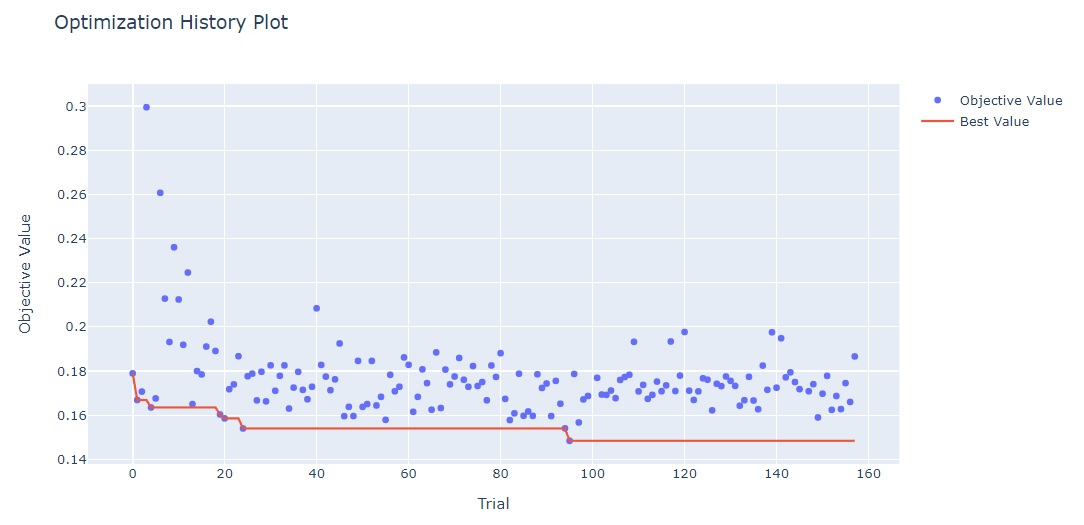

In [ ]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

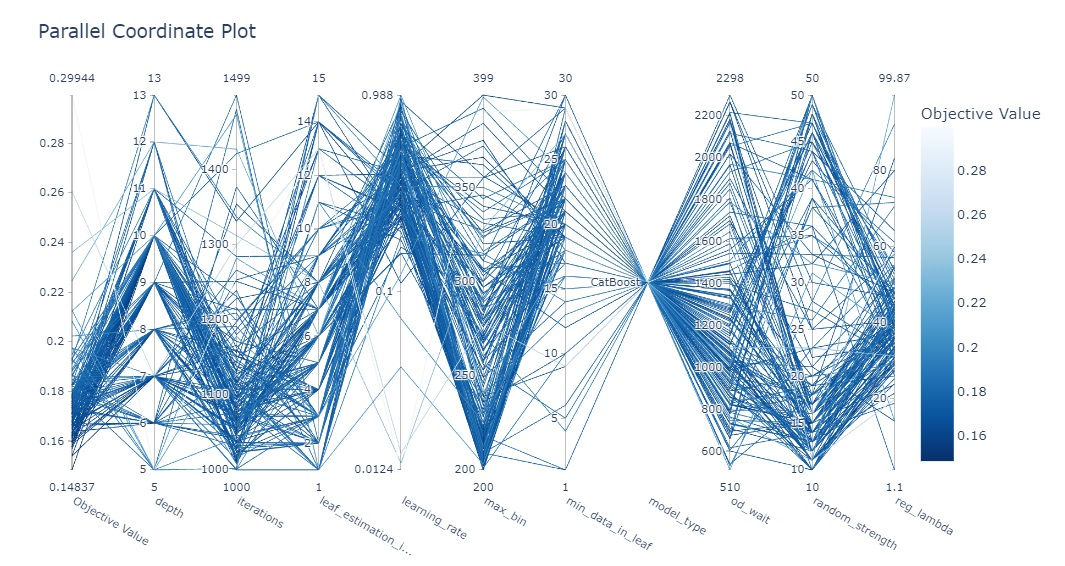

In [ ]:
optuna.visualization.plot_param_importances(study)

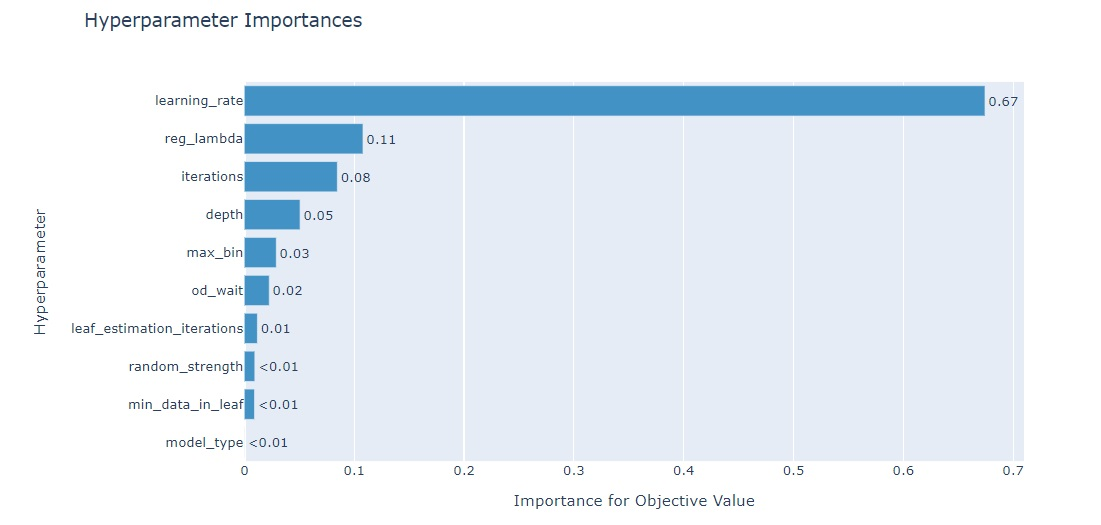

In [ ]:
feature_importance = model_catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(data_train.columns)[sorted_idx])
plt.title('Feature Importance')

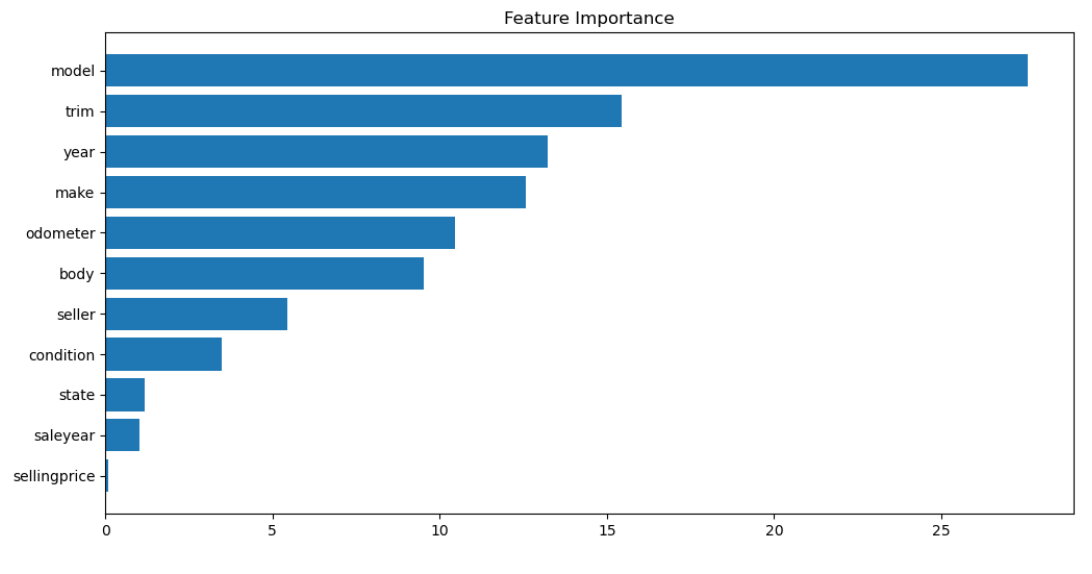

## Подготовка к отправке предсказаний для проверки

После подбора оптимальных гиперпараметров необходимо подготовить файл в формате csv с результатами предсказаний модели. Для этого выберем гиперпараметры лучшей попытки. Изменим количество иттераций на 25 000, таким образом можно еще немного улучшить результаты модели.

In [ ]:
best_trial = study.best_trial.params
best_trial["iterations"] = 25000
best_trial

Вставим лучшие гиперпараметры в модель и сделаем предсказания модели обученной на всех тренировочных данных.

In [ ]:
%%time

model_catboost = CatBoostRegressor(verbose=False, **best_trial)
model_catboost.fit(fin_features_te, data_target)
prediction_cat = model_catboost.predict(test_features_te)

Загрузим исходый файл с тестовыми данными, удалим оттуда все столбцы кроме vin и добавим столбец с предсказанной ценой. Сохраним результат.

In [ ]:
data_test2 = pd.read_csv('test.csv')
data_test2['sellingprice'] = prediction_cat
data_test2 = data_test2.drop(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state', 'condition', 'odometer', 
                             'color', 'interior', 'seller', 'saledate'], axis=1)
data_test2.to_csv('result_final_v0c.csv', index=False)

## Подведение результатов предсказаний модели

Итоговой результат предсказаний модели оценивается по метрике MAPE (Mean Absolute Percentage Error, средняя абсолютная ошибка в процентах). MAPE интерпретировать например значение MAPE равное 14 %, означает, что средняя разница между предсказанным и фактическим значениями составляет 14%. Чем меньше значение, тем точнее предсказывает модель.

После загрузки файла с предсказаниями модели и до окончания соревнований виден публичный результат 50% датасета. Таким образом можно понять какие изменения улучшают или ухудшают результат. Окончательный результат подводят по оставшимся 50% датасета, который станет известен после окончания соревнований. Этот результат будет немного другим по сравнению с публичным. 

Большое отклонение в результатах указывает на то, что модель несбалансирована и предсказывает первую часть намного лучше второй. С целью исключения такого влияния необходимо использовать кросс-валидацию при подборе оптимальных гиперпараметров. Ниже представлены результаты публичного и приватного результатов соревнований.

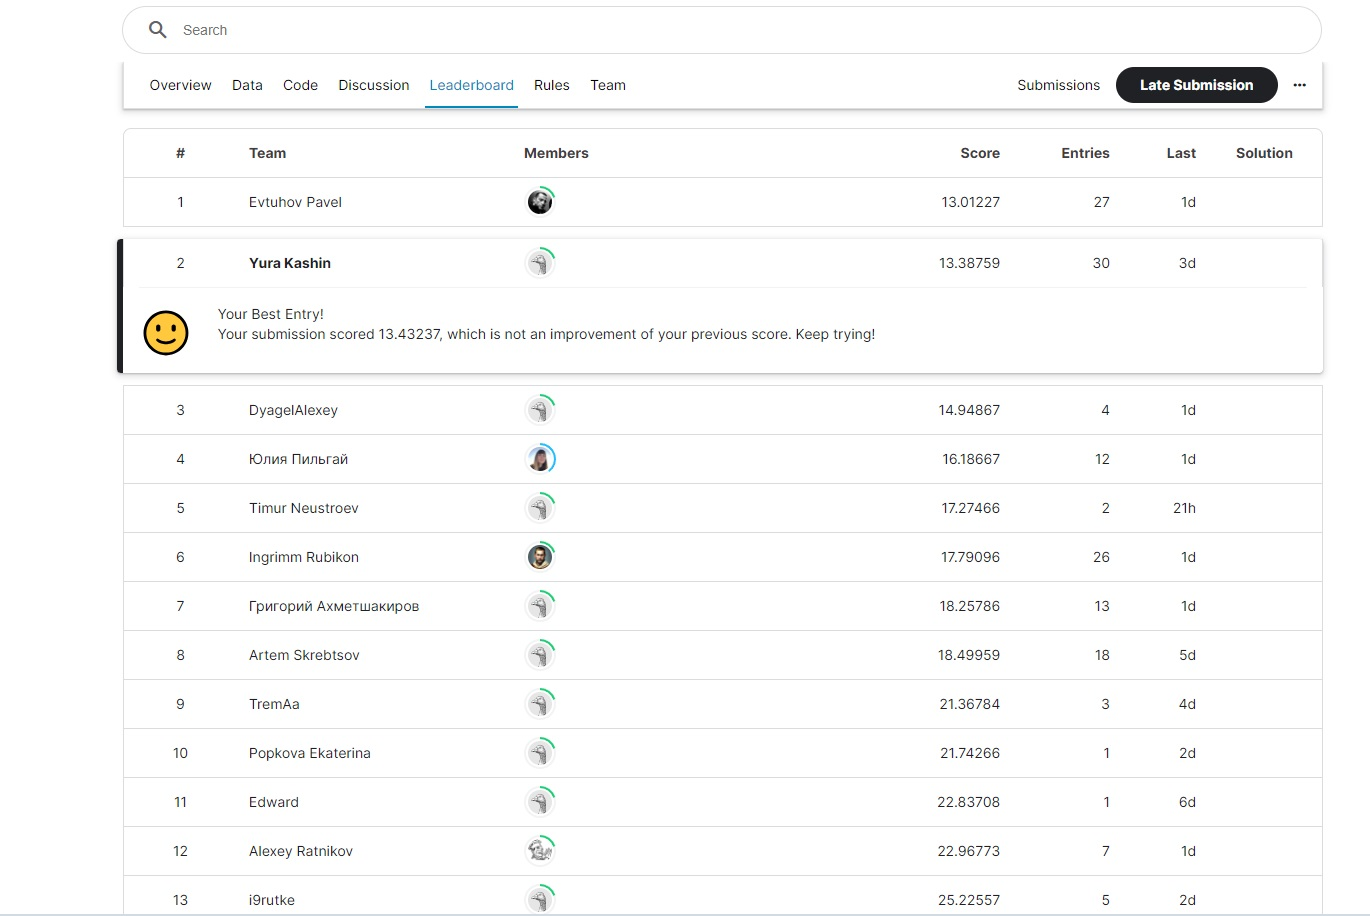

Как видно лучшее предсказание отстает от лидера на **0.37%**, хоть и держалось практически неделю на первом месте.

Далее можно посмотреть приватный результат, на основании которого и подводят итоги соревнований.

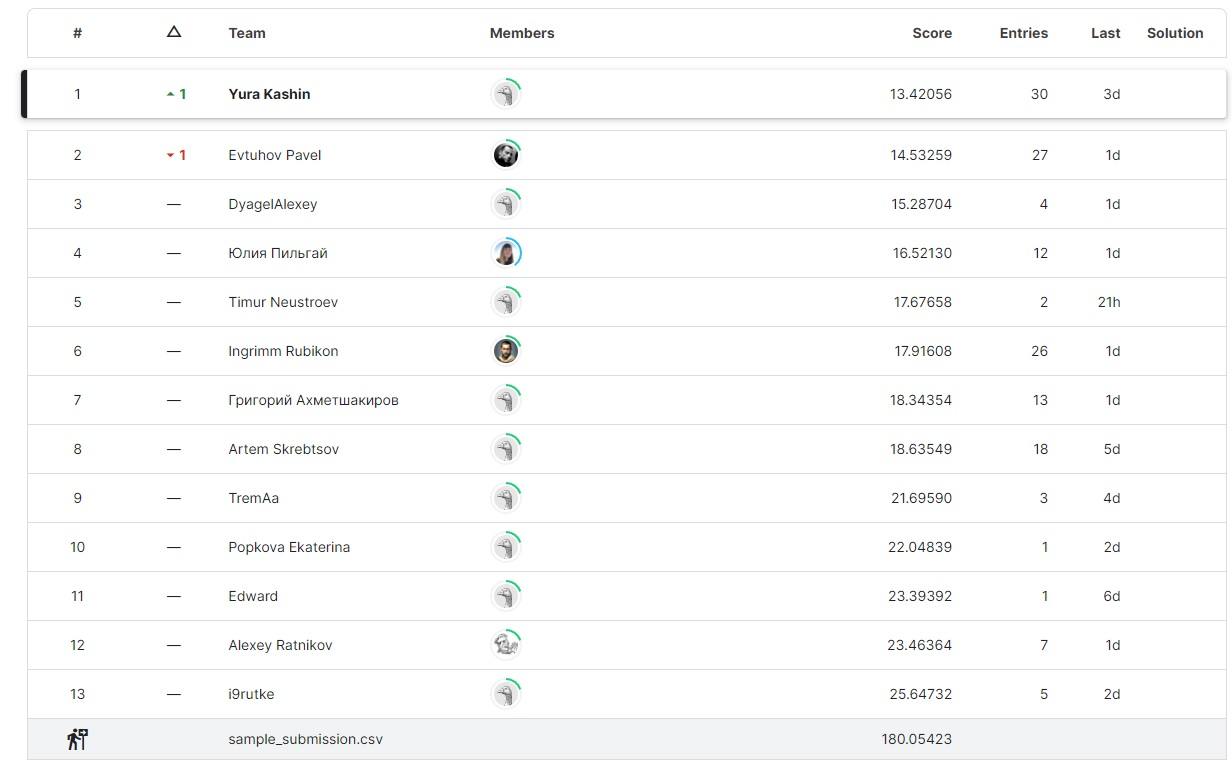

В итоге разница между обоими результатами составляет **0.04%**, что является самым малым отличием между обоими частями предсказаний. Но в данном случае стоит отметить, что этот результат получен на данных, в которых имеются ошибки в графе марка автомобиля. В коде парсинга информации с сайта министерства траспорта США вместо марки находилась модель авто. После обнаружения и устранения ошибки, а также остальных изменений получен другой результат, занимающий 2 место в личных submissions.

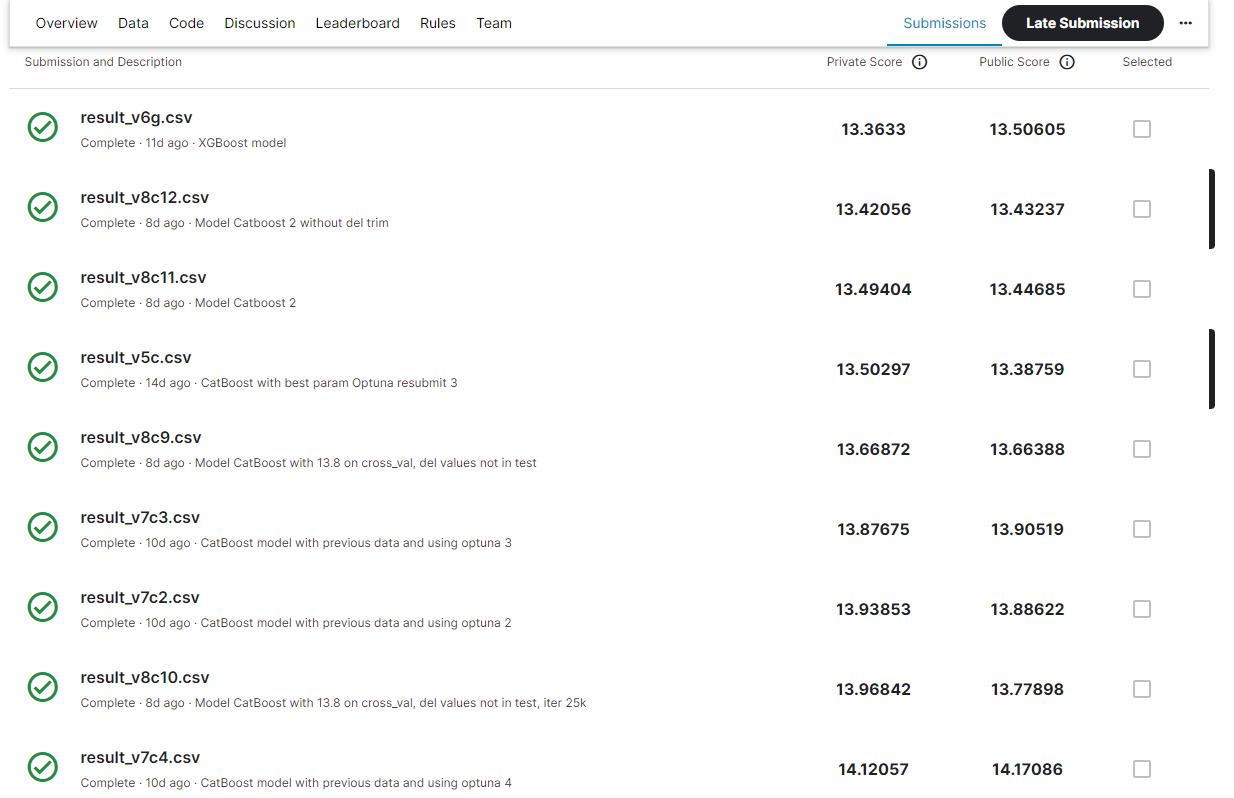